# Predicting House Sale Prices

In this project our goal is to predict housing prices using linear regression. 

The data we will be working with is housing data from Ames, Iowa from 2005 to 2010. General information on the dataset can be found [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) and column descriptions can be found [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ames = pd.read_csv('AmesHousing.tsv', sep = '\t')
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

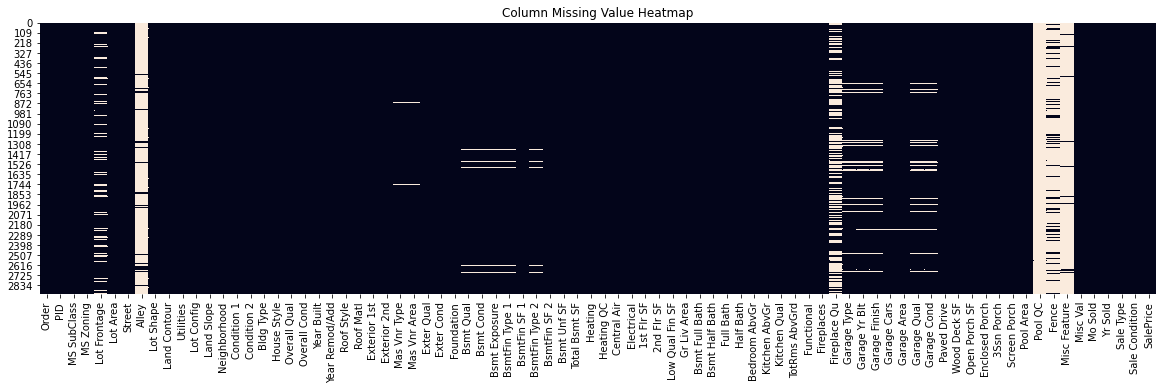

In [4]:
plt.figure(figsize = (20,5))
sns.heatmap(ames.isnull(), cbar = False)
plt.title('Column Missing Value Heatmap')
plt.show()

Our data is composed of 82 columns and 2930 rows of data. The columns are comprised of different features of a house, such as the year built and square footage of the lot the house is built on. Our target column for training our alogorithm will be the `SalePrice` column which is the price the house sold for. There is a mix of float, integer and string object columns. Null values are present at varying levels, but the bulk of the dataset is complete. The reasons for null values appear to be either as a result of a feature not being present on a property, such as with `Alley`, or an instance of an incomplete record. 

## Building the Linear Regression Model
We will use an iterative approach to building our model, starting very simple and building complexity as we test what has an impact on reducing our predictive error. 
### Baseline Workflow
Let's create a baseline workflow to gain a starting point we can build and improve upon. To do this we will create a series of nested functions that we will make iterative changes to as we attempt to improve the accuracy of our model. To start, we will use just one feature, `Gr Liv Area` - the square feet of living space above ground, to predict the `SalePrice` column.

In [5]:
def transform_features(dataframe):
    train = dataframe
    return train

def select_features(dataframe):
    train = transform_features(dataframe)
    train = train[['Gr Liv Area', 'SalePrice']]
    return train

def train_test(dataframe):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    
    # prepare the dataframe
    #stop_point = round(len(dataframe)*.8) # we want to split the df into 80/20
    stop_point = 1460
    train = dataframe[0:stop_point]
    test = dataframe[stop_point:]
    train = select_features(train)
    
    # train the model
    lr = LinearRegression()
    lr.fit(train[['Gr Liv Area']],train['SalePrice'])
    
    # make predictions on test data
    predictions = lr.predict(test[['Gr Liv Area']])
    
    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    
    return rmse

In [6]:
rmse = train_test(ames)
print(rmse)

57088.25161263909


Our model gave us a RMSE of $57,088. RMSE tells us the average distance our predicted values were from the actual values, so the lower we can get this number, the more, generally, accurate our model is. 

### Feature Engineering
Let's now we  move into the phase of cleaning our data and creating new features. Generally we will want to:
* remove columns that have 25% or more missing data 
* transform features into a format that can be understood by our model 
* create new features through a understanding of the existing features and by combining features.
We will make it so as many steps as possible occur within the transform_feature function, but let's do some evaluation along the way to familiarize ourselves with the unique problems this dataset may present.  "

#### Evaluating Columns with Many Missing Values
Let's look at columns with a high (>25%) percentage of missing values, determine if they are salvagable, and remove them if not.

In [7]:
# isolate columns >25% missing values)
over25_missing = ames.loc[:,ames.columns[ames.isnull().sum()/len(ames) > 0.25]]

In [8]:
over25_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Alley         198 non-null    object
 1   Fireplace Qu  1508 non-null   object
 2   Pool QC       13 non-null     object
 3   Fence         572 non-null    object
 4   Misc Feature  106 non-null    object
dtypes: object(5)
memory usage: 114.6+ KB


In [9]:
for column in over25_missing.columns:
    print(column)
    print(over25_missing[column].value_counts(dropna = False))
    print('\n')

Alley
NaN     2732
Grvl     120
Pave      78
Name: Alley, dtype: int64


Fireplace Qu
NaN    1422
Gd      744
TA      600
Fa       75
Po       46
Ex       43
Name: Fireplace Qu, dtype: int64


Pool QC
NaN    2917
Gd        4
Ex        4
TA        3
Fa        2
Name: Pool QC, dtype: int64


Fence
NaN      2358
MnPrv     330
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64


Misc Feature
NaN     2824
Shed      95
Gar2       5
Othr       4
Elev       1
TenC       1
Name: Misc Feature, dtype: int64




Referencing the column descriptions tells us that NA values in each of these columns represent features not being present. How we will handle these missing values will be different based on whether these columns indicate the presence or type of feature, or whether the column represents a gradient of quality for the feature. If the columns represents the presence or type of feature we will change this column to '(feature) not present' and transform the column into a series of dummy columns that indicate true or false on each type. If the column represents a gradient, we will treat these like a ordinal scale and consider the lack of presence a zero, followed by the lowest quality of the feature being one, and so one incrementing by one as the quality grade increases. 

These two types of transformations will be something we may be doing for several columns that don't have missing values, however, so for now let's just replace the missing values. 

In [10]:
def transform_features(dataframe):
    # replace nan values in instances of over 25% missing
    transformation_1 = dataframe.copy()
    over25_missing = dataframe.loc[:,transformation_1.columns[transformation_1.isnull().sum()/len(transformation_1) > 0.25]]
    for column in over25_missing.columns:
        cat_name = column.split()[0]
        na_label = "no_{}".format(cat_name)
        transformation_1[column] = transformation_1[column].fillna(na_label)
    
    train = transformation_1
    return train

def select_features(dataframe):
    train = transform_features(dataframe)
    train = train[['Gr Liv Area', 'SalePrice']]
    return train

def train_test(dataframe):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    
    # prepare the dataframe
    #stop_point = round(len(dataframe)*.8) # we want to split the df into 80/20
    stop_point = 1460
    train = dataframe[0:stop_point]
    test = dataframe[stop_point:]
    train = select_features(train)
    
    # train the model
    lr = LinearRegression()
    lr.fit(train[['Gr Liv Area']],train['SalePrice'])
    
    # make predictions on test data
    predictions = lr.predict(test[['Gr Liv Area']])
    
    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    
    return rmse

Our goal is to encode each of these steps into a function that can handle the dataset from its baseline form, so let's create a copy at each transformation so we can keep track of the state at each transformation while keeping the initial dataframe intact. 

In [11]:
transformation_1 = transform_features(ames)
for column in over25_missing.columns:
    print(column)
    print(transformation_1[column].value_counts(dropna = False))
    print('\n')

Alley
no_Alley    2732
Grvl         120
Pave          78
Name: Alley, dtype: int64


Fireplace Qu
no_Fireplace    1422
Gd               744
TA               600
Fa                75
Po                46
Ex                43
Name: Fireplace Qu, dtype: int64


Pool QC
no_Pool    2917
Gd            4
Ex            4
TA            3
Fa            2
Name: Pool QC, dtype: int64


Fence
no_Fence    2358
MnPrv        330
GdPrv        118
GdWo         112
MnWw          12
Name: Fence, dtype: int64


Misc Feature
no_Misc    2824
Shed         95
Gar2          5
Othr          4
Elev          1
TenC          1
Name: Misc Feature, dtype: int64




#### Columns with Few Missing Values
Let's now evaluate the columns with missing values under 25%.

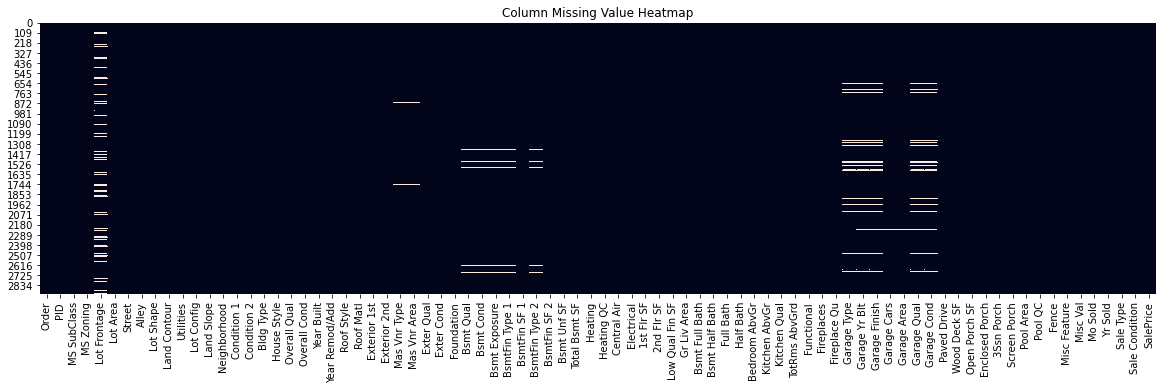

In [12]:
plt.figure(figsize = (20,5))
sns.heatmap(transformation_1.isnull(), cbar = False)
plt.title('Column Missing Value Heatmap')
plt.show()

In [13]:
# isolate columns with missing values under 25%
under25_missing = transformation_1.loc[:,transformation_1.columns[(transformation_1.isnull().sum()/len(transformation_1) <= 0.25) & 
                                                                 (transformation_1.isnull().sum()/len(transformation_1) > 0)]]

under25_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Frontage    2440 non-null   float64
 1   Mas Vnr Type    2907 non-null   object 
 2   Mas Vnr Area    2907 non-null   float64
 3   Bsmt Qual       2850 non-null   object 
 4   Bsmt Cond       2850 non-null   object 
 5   Bsmt Exposure   2847 non-null   object 
 6   BsmtFin Type 1  2850 non-null   object 
 7   BsmtFin SF 1    2929 non-null   float64
 8   BsmtFin Type 2  2849 non-null   object 
 9   BsmtFin SF 2    2929 non-null   float64
 10  Bsmt Unf SF     2929 non-null   float64
 11  Total Bsmt SF   2929 non-null   float64
 12  Electrical      2929 non-null   object 
 13  Bsmt Full Bath  2928 non-null   float64
 14  Bsmt Half Bath  2928 non-null   float64
 15  Garage Type     2773 non-null   object 
 16  Garage Yr Blt   2771 non-null   float64
 17  Garage Finish   2771 non-null   o

There is a mixture of float and string types that we will need to deal with. Before we decide whether to impute float values, let's first consider related categories. We can see several instances of basement and garage - if these features are missing from a house, it makes sense that there might be null values across rows where the feature is missing. Let's evaluate basement and garages further to decide how we want to handle these missing values.

In [14]:
basement_cols = [column for column in under25_missing.columns if "Bsmt" in column]
print(basement_cols) 

['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']


The column descriptions confirm that NA values indicate an absence of a basement. Therefore, for float values in these categories we can change to 0 and for descriptive object formats we can change these to 'no_basement'. We will transform these categorical features again when we create dummy values. 

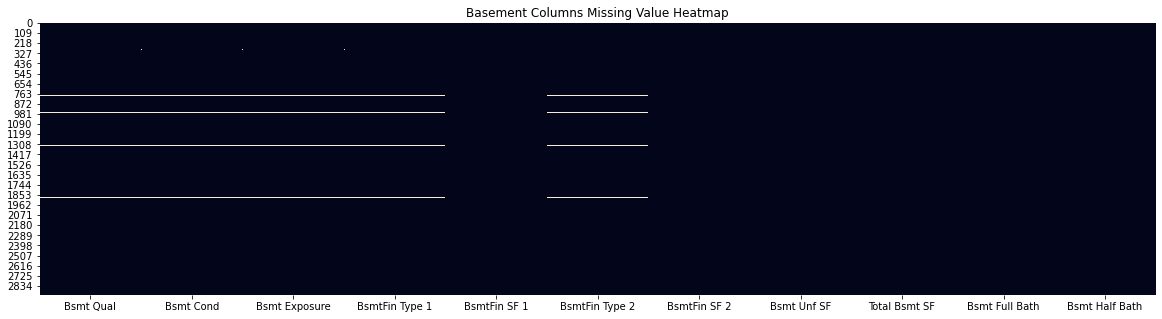

In [15]:
plt.figure(figsize = (20,5))
sns.heatmap(transformation_1[basement_cols].isnull(), cbar = False)
plt.title('Basement Columns Missing Value Heatmap')
plt.show()

In [16]:
# transform null float basement features to 0
transformation_2 = transformation_1.copy()
for column in basement_cols:
    if transformation_2[column].dtype == 'float64':
        print(column)
        transformation_2[column] = transformation_2[column].fillna(0)

BsmtFin SF 1
BsmtFin SF 2
Bsmt Unf SF
Total Bsmt SF
Bsmt Full Bath
Bsmt Half Bath


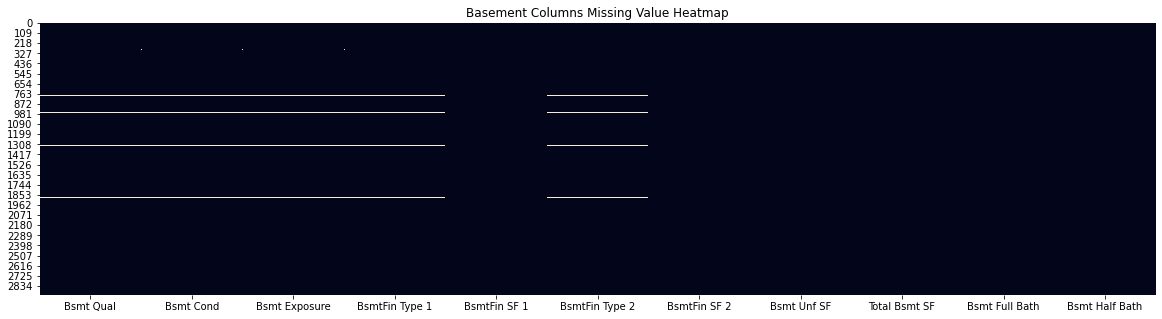

In [17]:
plt.figure(figsize = (20,5))
sns.heatmap(transformation_2[basement_cols].isnull(), cbar = False)
plt.title('Basement Columns Missing Value Heatmap')
plt.show()

In [18]:
# transform null to 'no basement' in category columns
for column in basement_cols:
    if transformation_2[column].dtype == 'object':
        print(column)
        transformation_2[column] = transformation_2[column].fillna('no_basement')

Bsmt Qual
Bsmt Cond
Bsmt Exposure
BsmtFin Type 1
BsmtFin Type 2


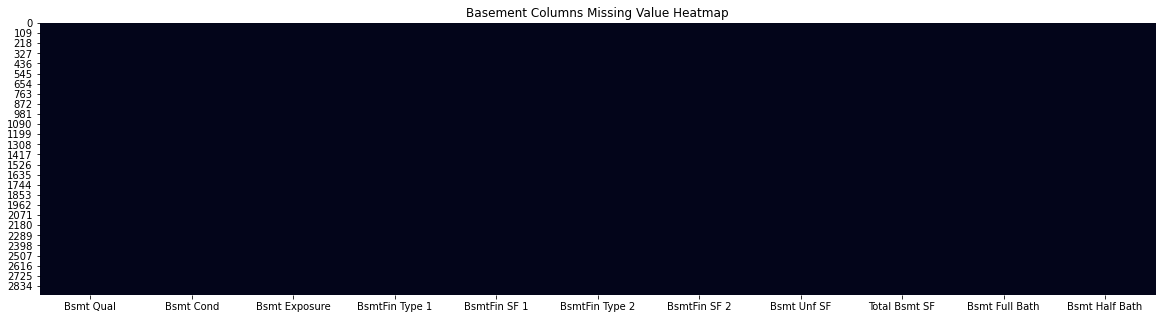

In [19]:
plt.figure(figsize = (20,5))
sns.heatmap(transformation_2[basement_cols].isnull(), cbar = False)
plt.title('Basement Columns Missing Value Heatmap')
plt.show()

Let's now do the same for the garage columns.

In [20]:
garage_cols = [column for column in under25_missing.columns if "Garage" in column]
print(garage_cols) 

['Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']


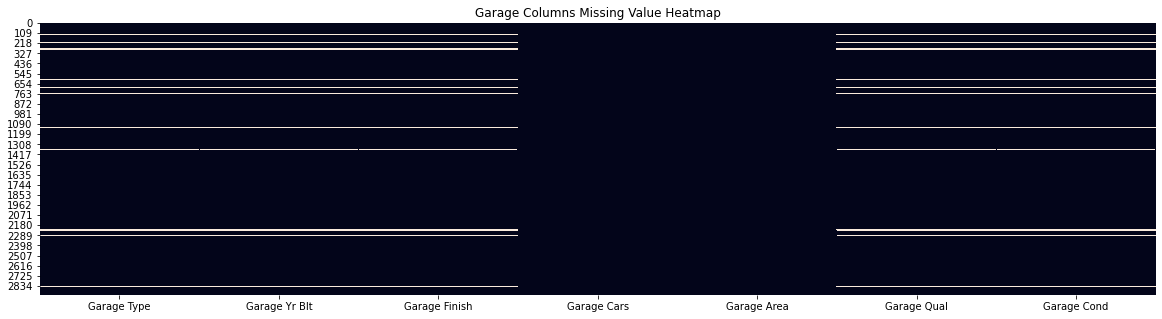

In [21]:
plt.figure(figsize = (20,5))
sns.heatmap(transformation_1[garage_cols].isnull(), cbar = False)
plt.title('Garage Columns Missing Value Heatmap')
plt.show()

Looking at the first heat map, it appeared that there may have been incosistency in the null values in the garage columns, however zooming in we no longer see this abberation. Let's go ahead and transform these now. 

In [22]:
# transform null float garage features to 0
for column in garage_cols:
    if transformation_2[column].dtype == 'float64':
        print(column)
        transformation_2[column] = transformation_2[column].fillna(0)

Garage Yr Blt
Garage Cars
Garage Area


In [23]:
# transform null to 'no garage' in category columns
for column in garage_cols:
    if transformation_2[column].dtype == 'object':
        print(column)
        transformation_2[column] = transformation_2[column].fillna('no_garage')

Garage Type
Garage Finish
Garage Qual
Garage Cond


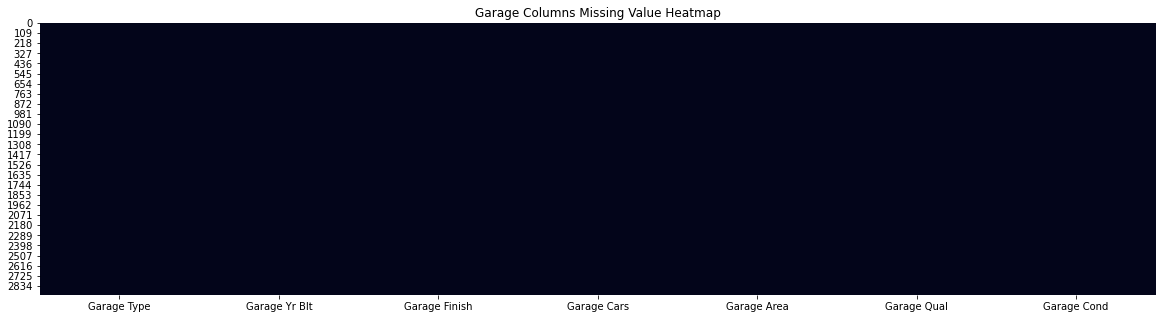

In [24]:
plt.figure(figsize = (20,5))
sns.heatmap(transformation_2[garage_cols].isnull(), cbar = False)
plt.title('Garage Columns Missing Value Heatmap')
plt.show()

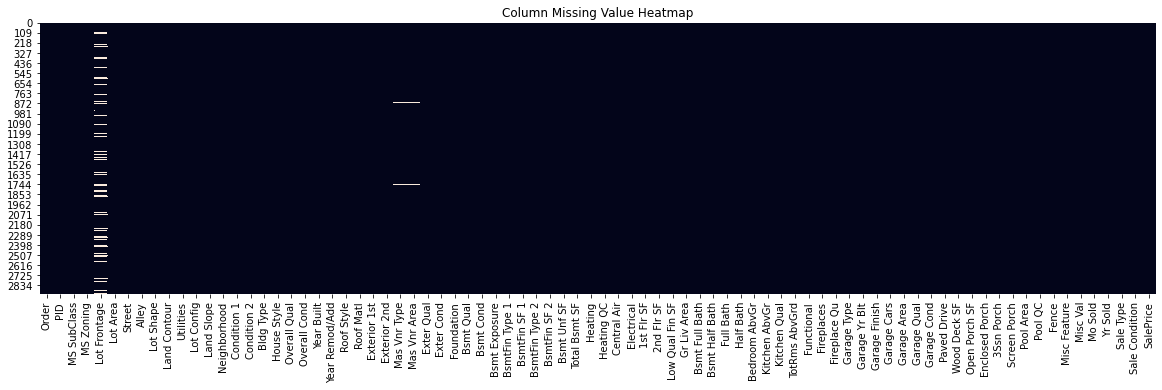

In [25]:
plt.figure(figsize = (20,5))
sns.heatmap(transformation_2.isnull(), cbar = False)
plt.title('Column Missing Value Heatmap')
plt.show()

We're now left with just two columns to fill na values. One deals with Lot Frontage - Lot Frontage is a function of land that connected to the property that connects to public property such as a road. Googling this, we can see that Lot Frontage can be zero if the property is surrounded by private property.

The other two columns deal with the type of veneer on a house. None is an option here, and because there are so few missing observations we will impute these with values with None.

In [26]:
transformation_2['Lot Frontage'].value_counts(dropna= False).sort_index()

21.0      50
22.0       1
24.0      49
25.0       1
26.0       3
        ... 
182.0      1
195.0      1
200.0      1
313.0      2
NaN      490
Name: Lot Frontage, Length: 129, dtype: int64

In [27]:
transformation_2['Lot Frontage'] = transformation_2['Lot Frontage'].fillna(0)

Finally, let's fill the na values for the veneer columns.

In [28]:
transformation_2['Mas Vnr Area'] = transformation_2['Mas Vnr Area'].fillna(0)
transformation_2['Mas Vnr Type'] = transformation_2['Mas Vnr Type'].fillna('None')

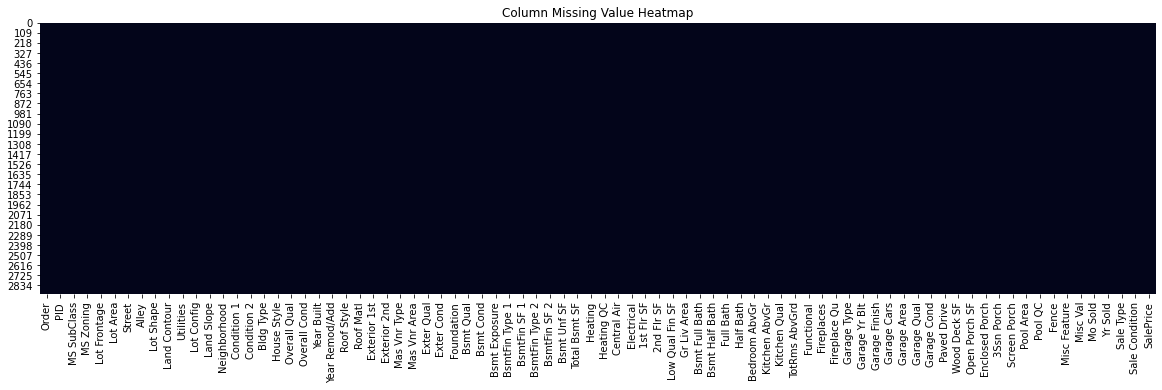

In [29]:
plt.figure(figsize = (20,5))
sns.heatmap(transformation_2.isnull(), cbar = False)
plt.title('Column Missing Value Heatmap')
plt.show()

Let's transfer the logic we created into our function.

In [30]:
def transform_features(dataframe):
    # [Transformation 1] replace nan values in instances of over 25% missing
    transformation_1 = dataframe.copy()
    over25_missing = dataframe.loc[:,transformation_1.columns[transformation_1.isnull().sum()/len(transformation_1) > 0.25]]
    for column in over25_missing.columns:
        cat_name = column.split()[0]
        na_label = "no_{}".format(cat_name)
        transformation_1[column] = transformation_1[column].fillna(na_label)
        
    # [Transformation 2] replace nan values under 25%
    transformation_2 = transformation_1.copy()
    under25_missing = transformation_1.loc[:,transformation_1.columns[(transformation_1.isnull().sum()/len(transformation_1) <= 0.25) & 
                                                                 (transformation_1.isnull().sum()/len(transformation_1) > 0)]]
    
    basement_cols = [column for column in under25_missing.columns if "Bsmt" in column]
    for column in basement_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in basement_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_basement')
    
    garage_cols = [column for column in under25_missing.columns if "Garage" in column]
    for column in garage_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in garage_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_garage')
            
    transformation_2['Lot Frontage'] = transformation_2['Lot Frontage'].fillna(0)
    transformation_2['Mas Vnr Area'] = transformation_2['Mas Vnr Area'].fillna(0)
    transformation_2['Mas Vnr Type'] = transformation_2['Mas Vnr Type'].fillna('None')
    
    
    train = transformation_2.copy()
    return train

def select_features(dataframe):
    train = transform_features(dataframe)
    train = train[['Gr Liv Area', 'SalePrice']]
    return train

def train_test(dataframe):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    
    # prepare the dataframe
    #stop_point = round(len(dataframe)*.8) # we want to split the df into 80/20
    stop_point = 1460
    train = dataframe[0:stop_point]
    test = dataframe[stop_point:]
    train = select_features(train)
    
    # train the model
    lr = LinearRegression()
    lr.fit(train[['Gr Liv Area']],train['SalePrice'])
    
    # make predictions on test data
    predictions = lr.predict(test[['Gr Liv Area']])
    
    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    
    return rmse

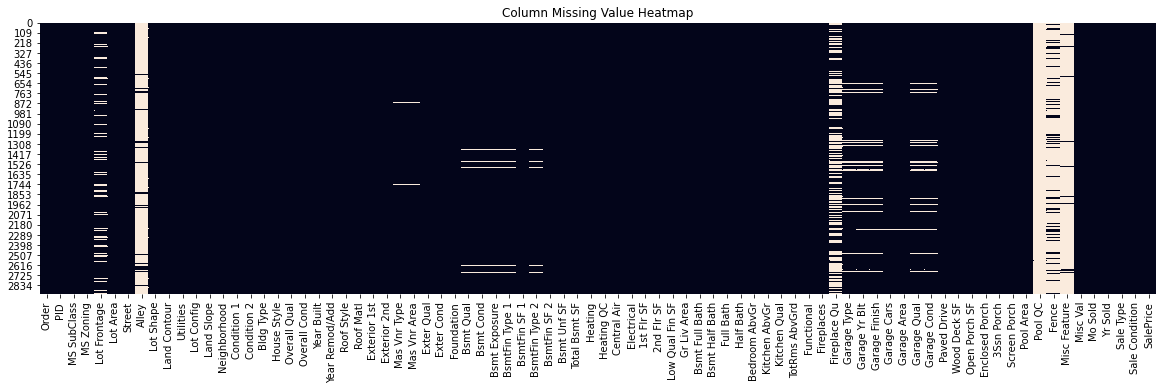

In [31]:
plt.figure(figsize = (20,5))
sns.heatmap(ames.isnull(), cbar = False)
plt.title('Column Missing Value Heatmap')
plt.show()

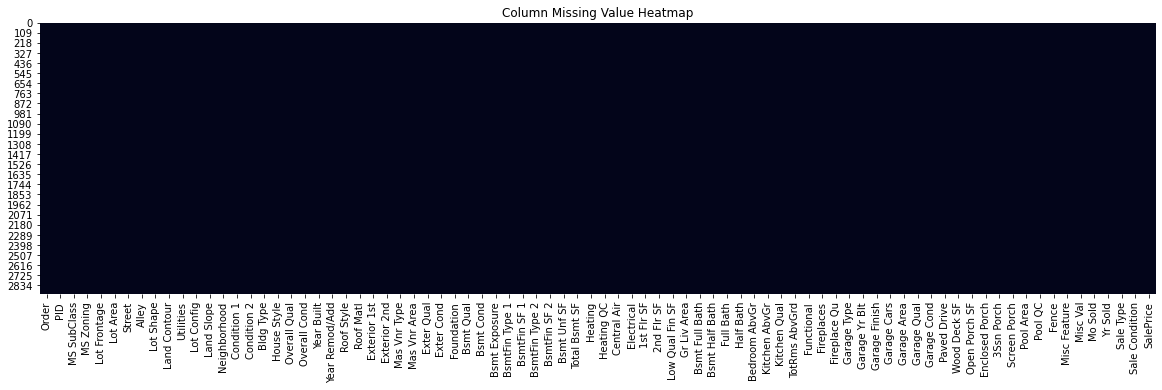

In [32]:
transformation_2 = transform_features(ames)
plt.figure(figsize = (20,5))
sns.heatmap(transformation_2.isnull(), cbar = False)
plt.title('Column Missing Value Heatmap')
plt.show()

We can see from the test that our function works as intended. Let's go to our next transformation stage.

### Categorical Feature Transformation
Categorical features can be used in Linear Regression, however they need to undergo transformation to make them numeric. One approach is to convert them into pandas categorical data which can then be encoded with numeric representations and the other is to use dummy coding techniques. The problem with the first approach is the inability to fairly weight each of the options, with the except of responses of likert or ranked format. Therefore, we will use the dummy coding technique to transform the descriptive categorical features and weighted categorical transformation for those on a likert scale.

#### Likert Transformation
Let's start by isolating the columns in likert or ranked format and presribing a numeric weight.  

In [33]:
transformation_3 = transformation_2.copy()

# all columns that need to be transformed
columns_on_scale = ['Land Slope','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond', 
                    'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC',
                    'Kitchen Qual','Fireplace Qu','Garage Qual','Garage Cond', 'Pool QC',
                    'Functional','Garage Finish','Paved Drive','Fence']

# columns with the same scale
columns_on_scale_1 = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual','Fireplace Qu',
                      'Garage Qual','Garage Cond','Pool QC']

# reorder scale_1
scale_1_order = ['Po','Fa','TA','Gd','Ex']

for column in columns_on_scale:
    transformation_3[column] = transformation_3[column].astype('category')    

for col in columns_on_scale_1:
    values = transformation_3[col].unique()
    instance = False
    last_val = ''
    
    for val in values:
        if val not in scale_1_order:
            last_value = val
            instance = True
    ordered_list = []
    
    for val in scale_1_order:
        if val in values:
            ordered_list.append(val)
            
    if instance == True:
        ordered_list.insert(0,last_value)
    
    transformation_3[col] = transformation_3[col].cat.reorder_categories(ordered_list, ordered = True)

In [34]:
remainder_scale = []
for value in columns_on_scale:
    if value not in columns_on_scale_1:
        remainder_scale.append(value)
        
print(remainder_scale)

['Land Slope', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Functional', 'Garage Finish', 'Paved Drive', 'Fence']


We will take a more manual approach for the remaining columns because they lack a pattern. Let's build a list of the ordered scales. The following scales were built using general intuition about what would be most preferable in a property and researching industry knowledge.

In [35]:
slope_scale = ['Sev','Mod','Gtl']
b_ex_scale = ['no_basement','No','Mn','Av','Gd']
b_finish_scale = ['no_basement','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
functional_scale = ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
gar_finish_scale = ['no_garage','Unf','RFn','Fin']
p_drive_scale = ['N','P','Y']
fence_scale = ['no_Fence','MnWw','GdWo','MnPrv','GdPrv']

Now let's reorder the four final likert categories.

In [36]:
transformation_3['Land Slope'] = transformation_3['Land Slope'].cat.reorder_categories(slope_scale, ordered = True)
transformation_3['Bsmt Exposure'] = transformation_3['Bsmt Exposure'].cat.reorder_categories(b_ex_scale, ordered = True)
transformation_3['BsmtFin Type 1'] = transformation_3['BsmtFin Type 1'].cat.reorder_categories(b_finish_scale, ordered = True)
transformation_3['BsmtFin Type 2'] = transformation_3['BsmtFin Type 2'].cat.reorder_categories(b_finish_scale, ordered = True)
transformation_3['Functional'] = transformation_3['Functional'].cat.reorder_categories(functional_scale, ordered = True)
transformation_3['Garage Finish'] = transformation_3['Garage Finish'].cat.reorder_categories(gar_finish_scale, ordered = True)
transformation_3['Paved Drive'] = transformation_3['Paved Drive'].cat.reorder_categories(p_drive_scale, ordered = True)
transformation_3['Fence'] = transformation_3['Fence'].cat.reorder_categories(fence_scale, ordered = True)

So that our model can access the numerical representations of the data, let's transform these into their numeric form.

In [37]:
category_columns = transformation_3.select_dtypes('category').columns
for cat in category_columns:
    transformation_3[cat] = transformation_3[cat].cat.codes

In [38]:
transformation_3[category_columns]

,Land Slope,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating QC,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence
0,2,1,2,3,4,4,4,1,1,2,7,4,3,3,3,1,0,0
1,2,1,2,3,3,1,3,2,2,2,7,0,1,3,3,2,0,3
2,2,1,2,3,3,1,5,1,2,3,7,0,1,3,3,2,0,0
3,2,2,2,3,3,1,5,1,4,4,7,3,3,3,3,2,0,0
4,2,1,2,4,3,1,6,1,3,2,7,3,3,3,3,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2,1,2,3,3,3,6,1,2,2,7,0,1,3,3,2,0,4
2926,1,1,2,4,3,3,4,5,2,2,7,0,1,3,3,2,0,3
2927,2,1,2,4,3,3,6,1,2,2,7,0,0,0,0,2,0,3
2928,1,1,2,4,3,3,5,2,3,2,7,3,2,3,3,2,0,0


#### Dummy Value Transformation
The second category of categorical values, those without explicit order or value attributions, will be transformed using dummy transformation. Rather than assigning arbitrary values to each of these feature's, we will instead transpose the unique attributes into columns and each row will be a boolean True/False as to whether each row has that attribute present. 

Let's build this now.

In [39]:
transformation_4 = transformation_3.copy()
dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                 'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                 'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                 'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                 'Misc Feature','Sale Type','Sale Condition', 'Garage Type']

# transform attributes to dummy columns and rename dummy columns
for col in dummy_columns:
    dummy_col = pd.get_dummies(transformation_4[col])
    dummy_column_names = dummy_col.columns
    new_dummy_column_names = {}
    for column in dummy_column_names:
        new_dummy_column_names[column] = str(col)+'_'+str(column)
    dummy_col = dummy_col.rename(columns = new_dummy_column_names)
    transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
    del transformation_4[col]

Let's double check that we did not miss any categorical columns.

In [40]:
used_categories = dummy_columns + columns_on_scale
all_objects = ames.select_dtypes('object').columns
unused_objects = []

for col in all_objects:
    if col not in used_categories:
        unused_objects.append(col)
print(unused_objects)

['Central Air']


In [41]:
transformation_4['Central Air'].value_counts(dropna = False)

Y    2734
N     196
Name: Central Air, dtype: int64

For our final categorical column we will change Y values to 1 and N values to 0 to follow the dummy value pattern.

In [42]:
transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
transformation_4['Central Air'].value_counts()

1    2734
0     196
Name: Central Air, dtype: int64

Let's add transformation 3 and 4 to our function. When we do so, however, we will be adding a toggle that allows for having categories with a relative scale be scaled or to have these categories transformed into dummy columns. This will allow us to test which method is most effective. 

In [43]:
def transform_features(dataframe, all_dummies = False):
    # [Transformation 1] replace nan values in instances of over 25% missing
    transformation_1 = dataframe.copy()
    over25_missing = dataframe.loc[:,transformation_1.columns[transformation_1.isnull().sum()/len(transformation_1) > 0.25]]
    for column in over25_missing.columns:
        cat_name = column.split()[0]
        na_label = "no_{}".format(cat_name)
        transformation_1[column] = transformation_1[column].fillna(na_label)
        
    # [Transformation 2] replace nan values under 25%
    transformation_2 = transformation_1.copy()
    under25_missing = transformation_1.loc[:,transformation_1.columns[(transformation_1.isnull().sum()/len(transformation_1) <= 0.25) & 
                                                                 (transformation_1.isnull().sum()/len(transformation_1) > 0)]]
    
    basement_cols = [column for column in under25_missing.columns if "Bsmt" in column]
    for column in basement_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in basement_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_basement')
    
    garage_cols = [column for column in under25_missing.columns if "Garage" in column]
    for column in garage_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in garage_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_garage')
            
    transformation_2['Lot Frontage'] = transformation_2['Lot Frontage'].fillna(0)
    transformation_2['Mas Vnr Area'] = transformation_2['Mas Vnr Area'].fillna(0)
    transformation_2['Mas Vnr Type'] = transformation_2['Mas Vnr Type'].fillna('None')
    
    # [Transformation 3&4 version 1]
    # all columns that need to be transformed
    columns_on_scale = ['Land Slope','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond', 
                'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC',
                'Kitchen Qual','Fireplace Qu','Garage Qual','Garage Cond', 'Pool QC',
                'Functional','Garage Finish','Paved Drive','Fence']
    
    # [Transformation 3] map ordered category columns
    if all_dummies == False:    

        # columns with the same scale
        columns_on_scale_1 = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual','Fireplace Qu',
                              'Garage Qual','Garage Cond','Pool QC']
        
        transformation_3 = transformation_2.copy()
        scale_1_order = ['Po','Fa','TA','Gd','Ex']

        for column in columns_on_scale:
            transformation_3[column] = transformation_3[column].astype('category')    

        for col in columns_on_scale_1:
            values = transformation_3[col].unique()
            instance = False
            last_val = ''

            for val in values:
                if val not in scale_1_order:
                    last_value = val
                    instance = True
            ordered_list = []

            for val in scale_1_order:
                if val in values:
                    ordered_list.append(val)

            if instance == True:
                ordered_list.insert(0,last_value)

            transformation_3[col] = transformation_3[col].cat.reorder_categories(ordered_list, ordered = True)

        # unpatterned ordered scales
        slope_scale = ['Sev','Mod','Gtl']
        b_ex_scale = ['no_basement','No','Mn','Av','Gd']
        b_finish_scale = ['no_basement','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
        functional_scale = ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
        gar_finish_scale = ['no_garage','Unf','RFn','Fin']
        p_drive_scale = ['N','P','Y']
        fence_scale = ['no_Fence','MnWw','GdWo','MnPrv','GdPrv']

        transformation_3['Land Slope'] = transformation_3['Land Slope'].cat.reorder_categories(slope_scale, ordered = True)
        transformation_3['Bsmt Exposure'] = transformation_3['Bsmt Exposure'].cat.reorder_categories(b_ex_scale, ordered = True)
        transformation_3['BsmtFin Type 1'] = transformation_3['BsmtFin Type 1'].cat.reorder_categories(b_finish_scale, ordered = True)
        transformation_3['BsmtFin Type 2'] = transformation_3['BsmtFin Type 2'].cat.reorder_categories(b_finish_scale, ordered = True)
        transformation_3['Functional'] = transformation_3['Functional'].cat.reorder_categories(functional_scale, ordered = True)
        transformation_3['Garage Finish'] = transformation_3['Garage Finish'].cat.reorder_categories(gar_finish_scale, ordered = True)
        transformation_3['Paved Drive'] = transformation_3['Paved Drive'].cat.reorder_categories(p_drive_scale, ordered = True)
        transformation_3['Fence'] = transformation_3['Fence'].cat.reorder_categories(fence_scale, ordered = True)

        category_columns = transformation_3.select_dtypes('category').columns
        for cat in category_columns:
            transformation_3[cat] = transformation_3[cat].cat.codes

        # Transformation_4 
        transformation_4 = transformation_3.copy()

        dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                         'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                         'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                         'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                         'Misc Feature','Sale Type','Sale Condition', 'Garage Type'] 


        # transform attributes to dummy columns and rename dummy columns
        for col in dummy_columns:
            dummy_col = pd.get_dummies(transformation_4[col])
            dummy_column_names = dummy_col.columns
            new_dummy_column_names = {}
            for column in dummy_column_names:
                new_dummy_column_names[column] = str(col)+'_'+str(column)
            dummy_col = dummy_col.rename(columns = new_dummy_column_names)
            transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
            del transformation_4[col]

        transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
    else:
        transformation_4 = transformation_2.copy()
        
        dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                         'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                         'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                         'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                         'Misc Feature','Sale Type','Sale Condition', 'Garage Type'] + columns_on_scale


        # transform attributes to dummy columns and rename dummy columns
        for col in dummy_columns:
            dummy_col = pd.get_dummies(transformation_4[col])
            dummy_column_names = dummy_col.columns
            new_dummy_column_names = {}
            for column in dummy_column_names:
                new_dummy_column_names[column] = str(col)+'_'+str(column)
            dummy_col = dummy_col.rename(columns = new_dummy_column_names)
            transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
            del transformation_4[col]
        transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
    
    train = transformation_4.copy()
    return train

def select_features(dataframe):
    train = transform_features(dataframe)
    train = train[['Gr Liv Area', 'SalePrice']]
    return train

def train_test(dataframe):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    
    # prepare the dataframe
    #stop_point = round(len(dataframe)*.8) # we want to split the df into 80/20
    stop_point = 1460
    train = dataframe[0:stop_point]
    test = dataframe[stop_point:]
    train = select_features(train)
    
    # train the model
    lr = LinearRegression()
    lr.fit(train[['Gr Liv Area']],train['SalePrice'])
    
    # make predictions on test data
    predictions = lr.predict(test[['Gr Liv Area']])
    
    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    
    return rmse

In [44]:
train = transform_features(ames,all_dummies = False)
train.head()

,Order,PID,Lot Frontage,Lot Area,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_no_garage
0,1,526301100,141.0,31770,2,6,5,1960,1960,112.0,...,0,1,0,0,1,0,0,0,0,0
1,2,526350040,80.0,11622,2,5,6,1961,1961,0.0,...,0,1,0,0,1,0,0,0,0,0
2,3,526351010,81.0,14267,2,6,6,1958,1958,108.0,...,0,1,0,0,1,0,0,0,0,0
3,4,526353030,93.0,11160,2,7,5,1968,1968,0.0,...,0,1,0,0,1,0,0,0,0,0
4,5,527105010,74.0,13830,2,5,5,1997,1998,0.0,...,0,1,0,0,1,0,0,0,0,0


We've created many columns. Let's evaluate whether there are any issues with repeated values.

In [45]:
columns = train.columns

In [46]:
column_count = {}
for col in columns:
    if col not in column_count:
        column_count[col] = 1
    else:
        column_count[col] += 1

sorted(column_count.items(), key = lambda item: item[1])

[('Order', 1),
 ('PID', 1),
 ('Lot Frontage', 1),
 ('Lot Area', 1),
 ('Land Slope', 1),
 ('Overall Qual', 1),
 ('Overall Cond', 1),
 ('Year Built', 1),
 ('Year Remod/Add', 1),
 ('Mas Vnr Area', 1),
 ('Exter Qual', 1),
 ('Exter Cond', 1),
 ('Bsmt Qual', 1),
 ('Bsmt Cond', 1),
 ('Bsmt Exposure', 1),
 ('BsmtFin Type 1', 1),
 ('BsmtFin SF 1', 1),
 ('BsmtFin Type 2', 1),
 ('BsmtFin SF 2', 1),
 ('Bsmt Unf SF', 1),
 ('Total Bsmt SF', 1),
 ('Heating QC', 1),
 ('Central Air', 1),
 ('1st Flr SF', 1),
 ('2nd Flr SF', 1),
 ('Low Qual Fin SF', 1),
 ('Gr Liv Area', 1),
 ('Bsmt Full Bath', 1),
 ('Bsmt Half Bath', 1),
 ('Full Bath', 1),
 ('Half Bath', 1),
 ('Bedroom AbvGr', 1),
 ('Kitchen AbvGr', 1),
 ('Kitchen Qual', 1),
 ('TotRms AbvGrd', 1),
 ('Functional', 1),
 ('Fireplaces', 1),
 ('Fireplace Qu', 1),
 ('Garage Yr Blt', 1),
 ('Garage Finish', 1),
 ('Garage Cars', 1),
 ('Garage Area', 1),
 ('Garage Qual', 1),
 ('Garage Cond', 1),
 ('Paved Drive', 1),
 ('Wood Deck SF', 1),
 ('Open Porch SF', 1),
 ('

There are no duplicate columns. Let's move on to creating new features from existing ones.

### Transforming Numeric Features
The columns with year values are numeric, but don't provide useful information for linear regression. We'll need to make them relative to the sale date in order for them to be useful. To do this we will subtract the year feature columns from the `Yr Sold` column so that we have a relative age for the house feature at the time of sale. 

Let's first evaluate whether these columns need to be cleaned up in any way.

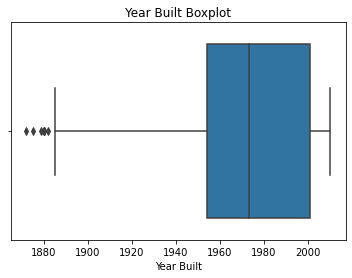

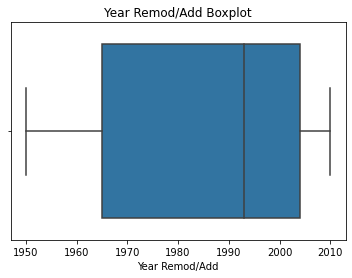

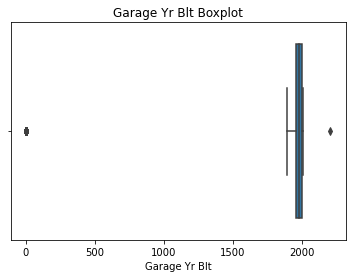

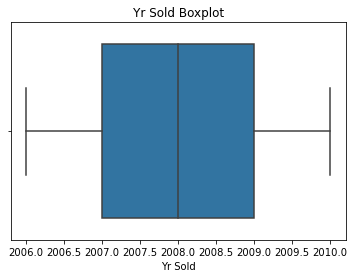

In [47]:
transformation_5 = transformation_4.copy()
year_features = ['Year Built','Year Remod/Add','Garage Yr Blt']
for col in year_features:
    sns.boxplot(x = transformation_5[col])
    plt.title("{} Boxplot".format(col))
    plt.show()
    
sns.boxplot(x = transformation_5['Yr Sold'])
plt.title("Yr Sold Boxplot")
plt.show()

The `Garage Yr Blt` boxplot shows outliers in both directions. On the right is a point(s) that haven't happend yet and on the left are zero results. We will need to investigate a possible entry error for the value(s) that are too high, however the zero values are a result of not every house having a garage. When we normalize the column we will keep the zero values as zero and increment each other by an additional year. That way garages built in the same year as a sale will start at 1 instead of zero, which will represent non-existant features.

Let's first replace the outlier that is too high then work around the zero values.

In [48]:
transformation_5.loc[transformation_5['Garage Yr Blt'] > 2022]['Garage Yr Blt']

2260    2207.0
Name: Garage Yr Blt, dtype: float64

We will assume that the garage was built in 2007.

In [49]:
transformation_5.loc[transformation_5['Garage Yr Blt'] > 2022,'Garage Yr Blt'] = 2007

Let's now work through the zero values.

Because we don't want to skew our data with a large pool of zeros at the beginning of our dataset and because we already have representation elsewhere for homes without garages, we will opt to impute the missing values with the mean of the distribution. This may cause some undesired effects, however may be more useful than dropping the column or rows entirely or imputing with zero.

In [50]:
# new column names
year_new_features = ['building_age','years_since_remod','garage_age']

for yf,nf in zip(year_features, year_new_features):
    transformation_5[nf] = transformation_5['Yr Sold'] - transformation_5[yf]
    transformation_5.loc[transformation_5[yf] == 0, nf] = 0
    transformation_5.loc[transformation_5[yf] != 0, nf] += 1
    transformation_5.loc[transformation_5[yf] == 0, nf] = round(np.mean(transformation_5.loc[transformation_5[yf] != 0, nf]))
    transformation_5 = transformation_5.drop(yf, axis = 1)
    
transformation_5 = transformation_5.drop('Yr Sold',axis = 1)

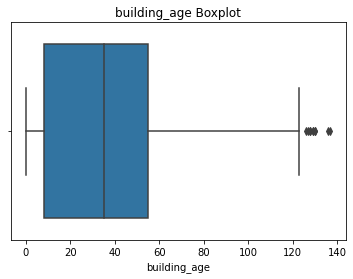

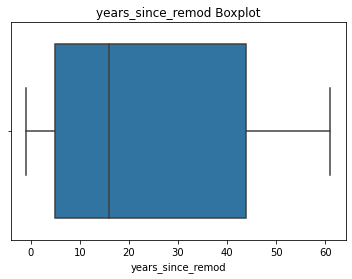

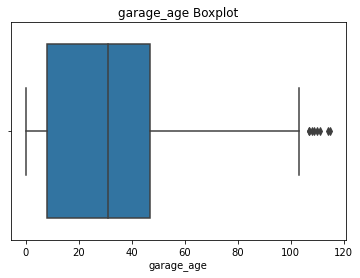

In [51]:
for col in year_new_features:
    sns.boxplot(x = transformation_5[col])
    plt.title("{} Boxplot".format(col))
    plt.show()

Our new columns appear to be in good shape. Let's add transformation_5 to our workflow.

In [52]:
def transform_features(dataframe, all_dummies = False):
    # [Transformation 1] replace nan values in instances of over 25% missing
    transformation_1 = dataframe.copy()
    over25_missing = dataframe.loc[:,transformation_1.columns[transformation_1.isnull().sum()/len(transformation_1) > 0.25]]
    for column in over25_missing.columns:
        cat_name = column.split()[0]
        na_label = "no_{}".format(cat_name)
        transformation_1[column] = transformation_1[column].fillna(na_label)
        
    # [Transformation 2] replace nan values under 25%
    transformation_2 = transformation_1.copy()
    under25_missing = transformation_1.loc[:,transformation_1.columns[(transformation_1.isnull().sum()/len(transformation_1) <= 0.25) & 
                                                                 (transformation_1.isnull().sum()/len(transformation_1) > 0)]]
    
    basement_cols = [column for column in under25_missing.columns if "Bsmt" in column]
    for column in basement_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in basement_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_basement')
    
    garage_cols = [column for column in under25_missing.columns if "Garage" in column]
    for column in garage_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in garage_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_garage')
            
    transformation_2['Lot Frontage'] = transformation_2['Lot Frontage'].fillna(0)
    transformation_2['Mas Vnr Area'] = transformation_2['Mas Vnr Area'].fillna(0)
    transformation_2['Mas Vnr Type'] = transformation_2['Mas Vnr Type'].fillna('None')
    
    # [Transformation 3&4 version 1]
    # all columns that need to be transformed
    columns_on_scale = ['Land Slope','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond', 
                'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC',
                'Kitchen Qual','Fireplace Qu','Garage Qual','Garage Cond', 'Pool QC',
                'Functional','Garage Finish','Paved Drive','Fence']
    
    # [Transformation 3] map ordered category columns
    if all_dummies == False:    

        # columns with the same scale
        columns_on_scale_1 = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual','Fireplace Qu',
                              'Garage Qual','Garage Cond','Pool QC']
        
        transformation_3 = transformation_2.copy()
        scale_1_order = ['Po','Fa','TA','Gd','Ex']

        for column in columns_on_scale:
            transformation_3[column] = transformation_3[column].astype('category')    

        for col in columns_on_scale_1:
            values = transformation_3[col].unique()
            instance = False
            last_val = ''

            for val in values:
                if val not in scale_1_order:
                    last_value = val
                    instance = True
            ordered_list = []

            for val in scale_1_order:
                if val in values:
                    ordered_list.append(val)

            if instance == True:
                ordered_list.insert(0,last_value)

            transformation_3[col] = transformation_3[col].cat.reorder_categories(ordered_list, ordered = True)

        # unpatterned ordered scales
        slope_scale = ['Sev','Mod','Gtl']
        b_ex_scale = ['no_basement','No','Mn','Av','Gd']
        b_finish_scale = ['no_basement','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
        functional_scale = ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
        gar_finish_scale = ['no_garage','Unf','RFn','Fin']
        p_drive_scale = ['N','P','Y']
        fence_scale = ['no_Fence','MnWw','GdWo','MnPrv','GdPrv']

        transformation_3['Land Slope'] = transformation_3['Land Slope'].cat.reorder_categories(slope_scale, ordered = True)
        transformation_3['Bsmt Exposure'] = transformation_3['Bsmt Exposure'].cat.reorder_categories(b_ex_scale, ordered = True)
        transformation_3['BsmtFin Type 1'] = transformation_3['BsmtFin Type 1'].cat.reorder_categories(b_finish_scale, ordered = True)
        transformation_3['BsmtFin Type 2'] = transformation_3['BsmtFin Type 2'].cat.reorder_categories(b_finish_scale, ordered = True)
        transformation_3['Functional'] = transformation_3['Functional'].cat.reorder_categories(functional_scale, ordered = True)
        transformation_3['Garage Finish'] = transformation_3['Garage Finish'].cat.reorder_categories(gar_finish_scale, ordered = True)
        transformation_3['Paved Drive'] = transformation_3['Paved Drive'].cat.reorder_categories(p_drive_scale, ordered = True)
        transformation_3['Fence'] = transformation_3['Fence'].cat.reorder_categories(fence_scale, ordered = True)

        category_columns = transformation_3.select_dtypes('category').columns
        for cat in category_columns:
            transformation_3[cat] = transformation_3[cat].cat.codes

        # Transformation_4 
        transformation_4 = transformation_3.copy()

        dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                         'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                         'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                         'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                         'Misc Feature','Sale Type','Sale Condition', 'Garage Type'] 


        # transform attributes to dummy columns and rename dummy columns
        for col in dummy_columns:
            dummy_col = pd.get_dummies(transformation_4[col])
            dummy_column_names = dummy_col.columns
            new_dummy_column_names = {}
            for column in dummy_column_names:
                new_dummy_column_names[column] = str(col)+'_'+str(column)
            dummy_col = dummy_col.rename(columns = new_dummy_column_names)
            transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
            del transformation_4[col]

        transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
    else:
        transformation_4 = transformation_2.copy()
        
        dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                         'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                         'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                         'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                         'Misc Feature','Sale Type','Sale Condition', 'Garage Type'] + columns_on_scale


        # transform attributes to dummy columns and rename dummy columns
        for col in dummy_columns:
            dummy_col = pd.get_dummies(transformation_4[col])
            dummy_column_names = dummy_col.columns
            new_dummy_column_names = {}
            for column in dummy_column_names:
                new_dummy_column_names[column] = str(col)+'_'+str(column)
            dummy_col = dummy_col.rename(columns = new_dummy_column_names)
            transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
            del transformation_4[col]
        transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
    
    # [transformation 5] Relative age column creation
    transformation_5 = transformation_4.copy()
    
    year_features = ['Year Built','Year Remod/Add','Garage Yr Blt']
    
    year_new_features = ['building_age','years_since_remod','garage_age']
    
    transformation_5.loc[transformation_5['Garage Yr Blt'] > 2022,'Garage Yr Blt'] = 2007


    for yf,nf in zip(year_features, year_new_features):
        transformation_5[nf] = transformation_5['Yr Sold'] - transformation_5[yf]
        transformation_5.loc[transformation_5[yf] == 0, nf] = 0
        transformation_5.loc[transformation_5[yf] != 0, nf] += 1
        transformation_5.loc[transformation_5[yf] == 0, nf] = round(np.mean(transformation_5.loc[transformation_5[yf] != 0, nf]))
        transformation_5 = transformation_5.drop(yf, axis = 1)

    transformation_5 = transformation_5.drop('Yr Sold',axis = 1)
    
    train = transformation_5.copy()
    return train

def select_features(dataframe):
    train = transform_features(dataframe)
    train = train[['Gr Liv Area', 'SalePrice']]
    return train

def train_test(dataframe):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    
    # prepare the dataframe
    #stop_point = round(len(dataframe)*.8) # we want to split the df into 80/20
    stop_point = 1460
    train = dataframe[0:stop_point]
    test = dataframe[stop_point:]
    train = select_features(train)
    
    # train the model
    lr = LinearRegression()
    lr.fit(train[['Gr Liv Area']],train['SalePrice'])
    
    # make predictions on test data
    predictions = lr.predict(test[['Gr Liv Area']])
    
    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    
    return rmse

In [53]:
train = transform_features(ames)

In [54]:
train.head()

,Order,PID,Lot Frontage,Lot Area,Land Slope,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,...,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_no_garage,building_age,years_since_remod,garage_age
0,1,526301100,141.0,31770,2,6,5,112.0,1,2,...,0,1,0,0,0,0,0,51,51,51.0
1,2,526350040,80.0,11622,2,5,6,0.0,1,2,...,0,1,0,0,0,0,0,50,50,50.0
2,3,526351010,81.0,14267,2,6,6,108.0,1,2,...,0,1,0,0,0,0,0,53,53,53.0
3,4,526353030,93.0,11160,2,7,5,0.0,2,2,...,0,1,0,0,0,0,0,43,43,43.0
4,5,527105010,74.0,13830,2,5,5,0.0,1,2,...,0,1,0,0,0,0,0,14,13,14.0


### Removing Unhelpful Columns

The `Order` and `PID` columns have no linear relationship with the `SalePrice` column at all. Let's remove them.

In [55]:
transformation_6 = transformation_5.copy()
transformation_6 = transformation_6.drop(['Order','PID'], axis = 1)

In [56]:
def transform_features(dataframe, all_dummies = False):
    # [Transformation 1] replace nan values in instances of over 25% missing
    transformation_1 = dataframe.copy()
    over25_missing = dataframe.loc[:,transformation_1.columns[transformation_1.isnull().sum()/len(transformation_1) > 0.25]]
    for column in over25_missing.columns:
        cat_name = column.split()[0]
        na_label = "no_{}".format(cat_name)
        transformation_1[column] = transformation_1[column].fillna(na_label)
        
    # [Transformation 2] replace nan values under 25%
    transformation_2 = transformation_1.copy()
    under25_missing = transformation_1.loc[:,transformation_1.columns[(transformation_1.isnull().sum()/len(transformation_1) <= 0.25) & 
                                                                 (transformation_1.isnull().sum()/len(transformation_1) > 0)]]
    
    basement_cols = [column for column in under25_missing.columns if "Bsmt" in column]
    for column in basement_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in basement_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_basement')
    
    garage_cols = [column for column in under25_missing.columns if "Garage" in column]
    for column in garage_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in garage_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_garage')
            
    transformation_2['Lot Frontage'] = transformation_2['Lot Frontage'].fillna(0)
    transformation_2['Mas Vnr Area'] = transformation_2['Mas Vnr Area'].fillna(0)
    transformation_2['Mas Vnr Type'] = transformation_2['Mas Vnr Type'].fillna('None')
    
    # [Transformation 3&4 version 1]
    # all columns that need to be transformed
    columns_on_scale = ['Land Slope','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond', 
                'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC',
                'Kitchen Qual','Fireplace Qu','Garage Qual','Garage Cond', 'Pool QC',
                'Functional','Garage Finish','Paved Drive','Fence']
    
    # [Transformation 3] map ordered category columns
    if all_dummies == False:    

        # columns with the same scale
        columns_on_scale_1 = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual','Fireplace Qu',
                              'Garage Qual','Garage Cond','Pool QC']
        
        transformation_3 = transformation_2.copy()
        scale_1_order = ['Po','Fa','TA','Gd','Ex']

        for column in columns_on_scale:
            transformation_3[column] = transformation_3[column].astype('category')    

        for col in columns_on_scale_1:
            values = transformation_3[col].unique()
            instance = False
            last_val = ''

            for val in values:
                if val not in scale_1_order:
                    last_value = val
                    instance = True
            ordered_list = []

            for val in scale_1_order:
                if val in values:
                    ordered_list.append(val)

            if instance == True:
                ordered_list.insert(0,last_value)

            transformation_3[col] = transformation_3[col].cat.reorder_categories(ordered_list, ordered = True)

        # unpatterned ordered scales
        slope_scale = ['Sev','Mod','Gtl']
        b_ex_scale = ['no_basement','No','Mn','Av','Gd']
        b_finish_scale = ['no_basement','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
        functional_scale = ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
        gar_finish_scale = ['no_garage','Unf','RFn','Fin']
        p_drive_scale = ['N','P','Y']
        fence_scale = ['no_Fence','MnWw','GdWo','MnPrv','GdPrv']

        transformation_3['Land Slope'] = transformation_3['Land Slope'].cat.reorder_categories(slope_scale, ordered = True)
        transformation_3['Bsmt Exposure'] = transformation_3['Bsmt Exposure'].cat.reorder_categories(b_ex_scale, ordered = True)
        transformation_3['BsmtFin Type 1'] = transformation_3['BsmtFin Type 1'].cat.reorder_categories(b_finish_scale, ordered = True)
        transformation_3['BsmtFin Type 2'] = transformation_3['BsmtFin Type 2'].cat.reorder_categories(b_finish_scale, ordered = True)
        transformation_3['Functional'] = transformation_3['Functional'].cat.reorder_categories(functional_scale, ordered = True)
        transformation_3['Garage Finish'] = transformation_3['Garage Finish'].cat.reorder_categories(gar_finish_scale, ordered = True)
        transformation_3['Paved Drive'] = transformation_3['Paved Drive'].cat.reorder_categories(p_drive_scale, ordered = True)
        transformation_3['Fence'] = transformation_3['Fence'].cat.reorder_categories(fence_scale, ordered = True)

        category_columns = transformation_3.select_dtypes('category').columns
        for cat in category_columns:
            transformation_3[cat] = transformation_3[cat].cat.codes

        # Transformation_4 
        transformation_4 = transformation_3.copy()

        dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                         'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                         'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                         'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                         'Misc Feature','Sale Type','Sale Condition', 'Garage Type'] 


        # transform attributes to dummy columns and rename dummy columns
        for col in dummy_columns:
            dummy_col = pd.get_dummies(transformation_4[col])
            dummy_column_names = dummy_col.columns
            new_dummy_column_names = {}
            for column in dummy_column_names:
                new_dummy_column_names[column] = str(col)+'_'+str(column)
            dummy_col = dummy_col.rename(columns = new_dummy_column_names)
            transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
            del transformation_4[col]

        transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
    else:
        transformation_4 = transformation_2.copy()
        
        dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                         'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                         'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                         'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                         'Misc Feature','Sale Type','Sale Condition', 'Garage Type'] + columns_on_scale


        # transform attributes to dummy columns and rename dummy columns
        for col in dummy_columns:
            dummy_col = pd.get_dummies(transformation_4[col])
            dummy_column_names = dummy_col.columns
            new_dummy_column_names = {}
            for column in dummy_column_names:
                new_dummy_column_names[column] = str(col)+'_'+str(column)
            dummy_col = dummy_col.rename(columns = new_dummy_column_names)
            transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
            del transformation_4[col]
        transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
    
    # [transformation 5] Relative age column creation
    transformation_5 = transformation_4.copy()
    
    year_features = ['Year Built','Year Remod/Add','Garage Yr Blt']
    
    year_new_features = ['building_age','years_since_remod','garage_age']
    
    transformation_5.loc[transformation_5['Garage Yr Blt'] > 2022,'Garage Yr Blt'] = 2007


    for yf,nf in zip(year_features, year_new_features):
        transformation_5[nf] = transformation_5['Yr Sold'] - transformation_5[yf]
        transformation_5.loc[transformation_5[yf] == 0, nf] = 0
        transformation_5.loc[transformation_5[yf] != 0, nf] += 1
        transformation_5.loc[transformation_5[yf] == 0, nf] = round(np.mean(transformation_5.loc[transformation_5[yf] != 0, nf]))
        transformation_5 = transformation_5.drop(yf, axis = 1)

    transformation_5 = transformation_5.drop('Yr Sold',axis = 1)
    
    # [Transformation 6] - removing unhelpful columns
    transformation_6 = transformation_5.copy()
    transformation_6 = transformation_6.drop(['Order','PID'], axis = 1)
    
    train = transformation_6.copy()
    return train

def select_features(dataframe):
    train = transform_features(dataframe)
    train = train[['Gr Liv Area', 'SalePrice']]
    return train

def train_test(dataframe):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    
    # prepare the dataframe
    #stop_point = round(len(dataframe)*.8) # we want to split the df into 80/20
    stop_point = 1460
    train = dataframe[0:stop_point]
    test = dataframe[stop_point:]
    train = select_features(train)
    
    # train the model
    lr = LinearRegression()
    lr.fit(train[['Gr Liv Area']],train['SalePrice'])
    
    # make predictions on test data
    predictions = lr.predict(test[['Gr Liv Area']])
    
    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    
    return rmse

In [57]:
transformation_6 = transform_features(ames)
transformation_6

,Lot Frontage,Lot Area,Land Slope,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,...,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_no_garage,building_age,years_since_remod,garage_age
0,141.0,31770,2,6,5,112.0,1,2,3,4,...,0,1,0,0,0,0,0,51,51,51.0
1,80.0,11622,2,5,6,0.0,1,2,3,3,...,0,1,0,0,0,0,0,50,50,50.0
2,81.0,14267,2,6,6,108.0,1,2,3,3,...,0,1,0,0,0,0,0,53,53,53.0
3,93.0,11160,2,7,5,0.0,2,2,3,3,...,0,1,0,0,0,0,0,43,43,43.0
4,74.0,13830,2,5,5,0.0,1,2,4,3,...,0,1,0,0,0,0,0,14,13,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,37.0,7937,2,6,6,0.0,1,2,3,3,...,0,0,0,0,0,1,0,23,23,23.0
2926,0.0,8885,1,5,5,0.0,1,2,4,3,...,0,1,0,0,0,0,0,24,24,24.0
2927,62.0,10441,2,5,5,0.0,1,2,4,3,...,0,0,0,0,0,0,1,15,15,31.0
2928,77.0,10010,1,5,5,0.0,1,2,4,3,...,0,1,0,0,0,0,0,33,32,32.0


### Feature Selection
Let's now try to narrow down which features will likely be useful in the model. We can do this by trying to correlate feature candidates with the `SalePrice` target, as well as removing features that have redundant impacts or low variance.

#### Sale Price Correlations

In [58]:
transformation_7 = transformation_6.copy()

In [59]:
correlations = transformation_7.corr()['SalePrice']
abs_correlations = abs(correlations).sort_values(ascending = False)[1:]

In [60]:
abs_correlations.head(40)

Overall Qual              0.799262
Gr Liv Area               0.706780
Exter Qual                0.697970
Kitchen Qual              0.672914
Garage Cars               0.647562
Garage Area               0.640138
Total Bsmt SF             0.632529
1st Flr SF                0.621676
Bsmt Qual                 0.607532
building_age              0.558907
Garage Finish             0.549899
Full Bath                 0.545604
years_since_remod         0.534940
Fireplace Qu              0.533901
Foundation_PConc          0.520966
garage_age                0.516518
Mas Vnr Area              0.502196
TotRms AbvGrd             0.495474
Fireplaces                0.474558
Heating QC                0.450325
Neighborhood_NridgHt      0.433299
BsmtFin SF 1              0.433147
Bsmt Exposure             0.411471
Mas Vnr Type_None         0.394743
Garage Type_Detchd        0.365074
MS SubClass_60            0.362327
Sale Type_New             0.354292
Sale Condition_Partial    0.350122
Foundation_CBlock   

We have some strong correlations to build on. Generally, anything below a .30 is considerd weak, between .30 and .7 is moderate, and .7 and above is highly correlated. We can include a variable in our function to expect a cutoff parameter and run some tests to optimize a cut-off. 

#### Colinearity
Colinearity is when selected feature columns are strongly correlated and essentially provide duplicate information. Let's define our minimum cutoff for correlations in the previous step as .20 then find sub-correlations between these features. For the colinearity cut-off, let's define that at 0.95.

In [61]:
colinearity_feature_targets = abs_correlations[abs_correlations > .3]
colinearity_correlations = abs(transformation_7[colinearity_feature_targets.index].corr())
colinearity_columns = colinearity_correlations.columns
colinearity_correlations = colinearity_correlations.reset_index()
colinearity_correlations['index'] = colinearity_correlations['index'].astype(str)
colinearity_correlations

,index,Overall Qual,Gr Liv Area,Exter Qual,Kitchen Qual,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,Bsmt Qual,...,Sale Condition_Partial,Foundation_CBlock,Garage Type_Attchd,BsmtFin Type 1,Exterior 1st_VinylSd,Exterior 2nd_VinylSd,Wood Deck SF,Open Porch SF,Mas Vnr Type_Stone,Lot Shape_Reg
0,Overall Qual,1.000000,0.570556,0.734317,0.675307,0.599547,0.563562,0.547766,0.477837,0.641866,...,0.331010,0.401357,0.357088,0.285952,0.368518,0.362348,0.255663,0.298412,0.290952,0.268446
1,Gr Liv Area,0.570556,1.000000,0.432351,0.428374,0.487829,0.483971,0.445108,0.562166,0.339173,...,0.174193,0.286229,0.146479,0.064543,0.180722,0.178287,0.250153,0.340857,0.148067,0.205422
2,Exter Qual,0.734317,0.432351,1.000000,0.715789,0.522565,0.501651,0.471574,0.401462,0.572981,...,0.385331,0.458057,0.300234,0.244419,0.435288,0.426968,0.215081,0.282350,0.303206,0.223600
3,Kitchen Qual,0.675307,0.428374,0.715789,1.000000,0.487147,0.472608,0.430184,0.393025,0.521318,...,0.343527,0.397824,0.270099,0.258632,0.374915,0.365714,0.229235,0.264868,0.280014,0.197137
4,Garage Cars,0.599547,0.487829,0.522565,0.487147,1.000000,0.889866,0.437856,0.439471,0.463790,...,0.262916,0.305927,0.302540,0.221321,0.341155,0.338646,0.240484,0.204535,0.251236,0.238767
5,Garage Area,0.563562,0.483971,0.501651,0.472608,0.889866,1.000000,0.485608,0.491208,0.422353,...,0.269200,0.240381,0.295391,0.235027,0.291042,0.290897,0.237682,0.233229,0.256246,0.211527
6,Total Bsmt SF,0.547766,0.445108,0.471574,0.430184,0.437856,0.485608,1.000000,0.800429,0.579380,...,0.258007,0.111170,0.381369,0.349757,0.178351,0.171690,0.230290,0.245941,0.282889,0.204326
7,1st Flr SF,0.477837,0.562166,0.401462,0.393025,0.439471,0.491208,0.800429,1.000000,0.297390,...,0.213985,0.090208,0.370248,0.211636,0.081164,0.079471,0.227131,0.238041,0.259862,0.201568
8,Bsmt Qual,0.641866,0.339173,0.572981,0.521318,0.463790,0.422353,0.579380,0.297390,1.000000,...,0.300940,0.296070,0.298744,0.422026,0.384357,0.375221,0.255690,0.240557,0.250118,0.250174
9,building_age,0.597021,0.242510,0.604611,0.533011,0.538121,0.480541,0.407603,0.310585,0.618606,...,0.344746,0.282205,0.470013,0.371995,0.520251,0.514577,0.228578,0.199692,0.247081,0.289765


In [62]:
column_hold = []
column_pair = []

for col in colinearity_columns:
    series = colinearity_correlations[col]
    colinearity_bool = ((series > 0.8) & (series != 1))
    if colinearity_bool.any():
        column_hold.append(col)
        col_counterpart = colinearity_correlations[colinearity_bool]['index'].values
        column_pair.append(list(col_counterpart))
        
#print(column_hold)
#print(column_pair)

final_removal = []

# of the colinear items keep the column with the largest amount of unique values
for h, p in zip(column_hold, column_pair):
    if h not in final_removal:
        largest = h
        value = transformation_7[h].nunique()

        for val in p:
            if val not in final_removal:
                if transformation_7[val].nunique() > value:
                    final_removal.append(largest)
                    largest = val
                    value = transformation_7[val].nunique()
                else:
                    final_removal.append(val)

#print(final_removal)
final_removal_set = set(final_removal)
print(final_removal_set)
final_set = [col for col in column_hold if col not in final_removal_set]
print(final_set)

{'TotRms AbvGrd', 'Sale Condition_Partial', 'Exterior 2nd_VinylSd', 'Fireplaces', 'Garage Cars', 'Total Bsmt SF'}
['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Fireplace Qu', 'Sale Type_New', 'Exterior 1st_VinylSd']


In the above code we looped through each column in the correlations dataframe, isolated colinear values for that column, and compared the values, keeping the more granular value, which we determined by the number of unique values. Looking at the output from our sample, we can validate that the values set for removal are those which logically are less granular or, in the case of basement squarefeet and first floor squarefeet, exactly equivalent. 

Let's now write code to remove these flagged colinear values from consideration and then we can add this to our workflow in a dynamic way. 

In [63]:
columns_to_keep = [col for col in colinearity_feature_targets.index if col not in final_removal_set]
columns_to_keep.append('SalePrice')
transformation_7 = transformation_7[columns_to_keep]
transformation_7

,Overall Qual,Gr Liv Area,Exter Qual,Kitchen Qual,Garage Area,1st Flr SF,Bsmt Qual,building_age,Garage Finish,Full Bath,...,Sale Type_New,Foundation_CBlock,Garage Type_Attchd,BsmtFin Type 1,Exterior 1st_VinylSd,Wood Deck SF,Open Porch SF,Mas Vnr Type_Stone,Lot Shape_Reg,SalePrice
0,6,1656,1,2,528.0,1656,3,51,3,1,...,0,1,1,4,0,210,62,1,0,215000
1,5,896,1,2,730.0,896,3,50,1,1,...,0,1,1,3,1,140,0,0,1,105000
2,6,1329,1,3,312.0,1329,3,53,1,1,...,0,1,1,5,0,393,36,0,0,172000
3,7,2110,2,4,522.0,2110,3,43,3,2,...,0,1,1,5,0,0,0,0,1,244000
4,5,1629,1,2,482.0,928,4,14,3,2,...,0,0,1,6,1,212,34,0,0,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,6,1003,1,2,588.0,1003,3,23,1,1,...,0,1,0,6,0,120,0,0,0,142500
2926,5,902,1,2,484.0,902,4,24,1,1,...,0,1,1,4,0,164,0,0,0,131000
2927,5,970,1,2,0.0,970,4,15,0,1,...,0,0,0,6,0,80,32,0,1,132000
2928,5,1389,1,2,418.0,1389,4,33,2,1,...,0,1,1,5,0,240,38,0,1,170000


In [64]:
def transform_features(dataframe, all_dummies = False):
    # [Transformation 1] replace nan values in instances of over 25% missing
    transformation_1 = dataframe.copy()
    over25_missing = dataframe.loc[:,transformation_1.columns[transformation_1.isnull().sum()/len(transformation_1) > 0.25]]
    for column in over25_missing.columns:
        cat_name = column.split()[0]
        na_label = "no_{}".format(cat_name)
        transformation_1[column] = transformation_1[column].fillna(na_label)
        
    # [Transformation 2] replace nan values under 25%
    transformation_2 = transformation_1.copy()
    under25_missing = transformation_1.loc[:,transformation_1.columns[(transformation_1.isnull().sum()/len(transformation_1) <= 0.25) & 
                                                                 (transformation_1.isnull().sum()/len(transformation_1) > 0)]]
    
    basement_cols = [column for column in under25_missing.columns if "Bsmt" in column]
    for column in basement_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in basement_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_basement')
    
    garage_cols = [column for column in under25_missing.columns if "Garage" in column]
    for column in garage_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in garage_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_garage')
            
    transformation_2['Lot Frontage'] = transformation_2['Lot Frontage'].fillna(0)
    transformation_2['Mas Vnr Area'] = transformation_2['Mas Vnr Area'].fillna(0)
    transformation_2['Mas Vnr Type'] = transformation_2['Mas Vnr Type'].fillna('None')
    
    # [Transformation 3&4 version 1]
    # all columns that need to be transformed
    columns_on_scale = ['Land Slope','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond', 
                'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC',
                'Kitchen Qual','Fireplace Qu','Garage Qual','Garage Cond', 'Pool QC',
                'Functional','Garage Finish','Paved Drive','Fence']
    
    # [Transformation 3] map ordered category columns
    if all_dummies == False:    

        # columns with the same scale
        columns_on_scale_1 = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual','Fireplace Qu',
                              'Garage Qual','Garage Cond','Pool QC']
        
        transformation_3 = transformation_2.copy()
        scale_1_order = ['Po','Fa','TA','Gd','Ex']

        for column in columns_on_scale:
            transformation_3[column] = transformation_3[column].astype('category')    

        for col in columns_on_scale_1:
            values = transformation_3[col].unique()
            instance = False
            last_val = ''

            for val in values:
                if val not in scale_1_order:
                    last_value = val
                    instance = True
            ordered_list = []

            for val in scale_1_order:
                if val in values:
                    ordered_list.append(val)

            if instance == True:
                ordered_list.insert(0,last_value)

            transformation_3[col] = transformation_3[col].cat.reorder_categories(ordered_list, ordered = True)

        # unpatterned ordered scales
        slope_scale = ['Sev','Mod','Gtl']
        b_ex_scale = ['no_basement','No','Mn','Av','Gd']
        b_finish_scale = ['no_basement','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
        functional_scale = ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
        gar_finish_scale = ['no_garage','Unf','RFn','Fin']
        p_drive_scale = ['N','P','Y']
        fence_scale = ['no_Fence','MnWw','GdWo','MnPrv','GdPrv']

        transformation_3['Land Slope'] = transformation_3['Land Slope'].cat.reorder_categories(slope_scale, ordered = True)
        transformation_3['Bsmt Exposure'] = transformation_3['Bsmt Exposure'].cat.reorder_categories(b_ex_scale, ordered = True)
        transformation_3['BsmtFin Type 1'] = transformation_3['BsmtFin Type 1'].cat.reorder_categories(b_finish_scale, ordered = True)
        transformation_3['BsmtFin Type 2'] = transformation_3['BsmtFin Type 2'].cat.reorder_categories(b_finish_scale, ordered = True)
        transformation_3['Functional'] = transformation_3['Functional'].cat.reorder_categories(functional_scale, ordered = True)
        transformation_3['Garage Finish'] = transformation_3['Garage Finish'].cat.reorder_categories(gar_finish_scale, ordered = True)
        transformation_3['Paved Drive'] = transformation_3['Paved Drive'].cat.reorder_categories(p_drive_scale, ordered = True)
        transformation_3['Fence'] = transformation_3['Fence'].cat.reorder_categories(fence_scale, ordered = True)

        category_columns = transformation_3.select_dtypes('category').columns
        for cat in category_columns:
            transformation_3[cat] = transformation_3[cat].cat.codes

        # Transformation_4 
        transformation_4 = transformation_3.copy()

        dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                         'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                         'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                         'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                         'Misc Feature','Sale Type','Sale Condition', 'Garage Type'] 


        # transform attributes to dummy columns and rename dummy columns
        for col in dummy_columns:
            dummy_col = pd.get_dummies(transformation_4[col])
            dummy_column_names = dummy_col.columns
            new_dummy_column_names = {}
            for column in dummy_column_names:
                new_dummy_column_names[column] = str(col)+'_'+str(column)
            dummy_col = dummy_col.rename(columns = new_dummy_column_names)
            transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
            del transformation_4[col]

        transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
    else:
        transformation_4 = transformation_2.copy()
        
        dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                         'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                         'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                         'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                         'Misc Feature','Sale Type','Sale Condition', 'Garage Type'] + columns_on_scale


        # transform attributes to dummy columns and rename dummy columns
        for col in dummy_columns:
            dummy_col = pd.get_dummies(transformation_4[col])
            dummy_column_names = dummy_col.columns
            new_dummy_column_names = {}
            for column in dummy_column_names:
                new_dummy_column_names[column] = str(col)+'_'+str(column)
            dummy_col = dummy_col.rename(columns = new_dummy_column_names)
            transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
            del transformation_4[col]
        transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
    
    # [transformation 5] Relative age column creation
    transformation_5 = transformation_4.copy()
    
    year_features = ['Year Built','Year Remod/Add','Garage Yr Blt']
    
    year_new_features = ['building_age','years_since_remod','garage_age']
    
    transformation_5.loc[transformation_5['Garage Yr Blt'] > 2022,'Garage Yr Blt'] = 2007


    for yf,nf in zip(year_features, year_new_features):
        transformation_5[nf] = transformation_5['Yr Sold'] - transformation_5[yf]
        transformation_5.loc[transformation_5[yf] == 0, nf] = 0
        transformation_5.loc[transformation_5[yf] != 0, nf] += 1
        transformation_5.loc[transformation_5[yf] == 0, nf] = round(np.mean(transformation_5.loc[transformation_5[yf] != 0, nf]))
        transformation_5 = transformation_5.drop(yf, axis = 1)

    transformation_5 = transformation_5.drop('Yr Sold',axis = 1)
    
    # [Transformation 6] - removing unhelpful columns
    transformation_6 = transformation_5.copy()
    transformation_6 = transformation_6.drop(['Order','PID'], axis = 1)
    
    train = transformation_6.copy()
    return train

def select_features(dataframe, correlation_tolerance = .3, colinearity_tolerance = .8, scaled_cat = False):
    train = transform_features(dataframe, all_dummies = scaled_cat)
    
    # [Transformation 7] - filtering by correlation and removing colinearities
    transformation_7 = train.copy()
    correlations = transformation_7.corr()['SalePrice']
    abs_correlations = abs(correlations).sort_values(ascending = False)[1:]

    colinearity_feature_targets = abs_correlations[abs_correlations > correlation_tolerance]
    colinearity_correlations = abs(transformation_7[colinearity_feature_targets.index].corr())
    colinearity_columns = colinearity_correlations.columns
    colinearity_correlations = colinearity_correlations.reset_index()
    colinearity_correlations['index'] = colinearity_correlations['index'].astype(str)

    column_hold = []
    column_pair = []

    for col in colinearity_columns:
        series = colinearity_correlations[col]
        colinearity_bool = ((series > colinearity_tolerance) & (series != 1))
        if colinearity_bool.any():
            column_hold.append(col)
            col_counterpart = colinearity_correlations[colinearity_bool]['index'].values
            column_pair.append(list(col_counterpart))

    #print(column_hold)
    #print(column_pair)

    final_removal = []

    # of the colinear items keep the column with the largest amount of unique values
    for h, p in zip(column_hold, column_pair):
        if h not in final_removal:
            largest = h
            value = transformation_7[h].nunique()

            for val in p:
                if val not in final_removal:
                    if transformation_7[val].nunique() > value:
                        final_removal.append(largest)
                        largest = val
                        value = transformation_7[val].nunique()
                    else:
                        final_removal.append(val)

    #print(final_removal)
    final_removal_set = set(final_removal)
    final_set = [col for col in column_hold if col not in final_removal_set]


    columns_to_keep = [col for col in colinearity_feature_targets.index if col not in final_removal_set]
    columns_to_keep.append('SalePrice')
    transformation_7 = transformation_7[columns_to_keep]
    
    train = transformation_7
    return train

def train_test(dataframe):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    
    # prepare the dataframe
    #stop_point = round(len(dataframe)*.8) # we want to split the df into 80/20
    stop_point = 1460
    train = dataframe[0:stop_point]
    test = dataframe[stop_point:]
    train = select_features(train)
    
    # train the model
    lr = LinearRegression()
    lr.fit(train[['Gr Liv Area']],train['SalePrice'])
    
    # make predictions on test data
    predictions = lr.predict(test[['Gr Liv Area']])
    
    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    
    return rmse

In [65]:
transformation_7 = select_features(ames)
transformation_7

,Overall Qual,Gr Liv Area,Exter Qual,Kitchen Qual,Garage Area,1st Flr SF,Bsmt Qual,building_age,Garage Finish,Full Bath,...,Sale Type_New,Foundation_CBlock,Garage Type_Attchd,BsmtFin Type 1,Exterior 1st_VinylSd,Wood Deck SF,Open Porch SF,Mas Vnr Type_Stone,Lot Shape_Reg,SalePrice
0,6,1656,1,2,528.0,1656,3,51,3,1,...,0,1,1,4,0,210,62,1,0,215000
1,5,896,1,2,730.0,896,3,50,1,1,...,0,1,1,3,1,140,0,0,1,105000
2,6,1329,1,3,312.0,1329,3,53,1,1,...,0,1,1,5,0,393,36,0,0,172000
3,7,2110,2,4,522.0,2110,3,43,3,2,...,0,1,1,5,0,0,0,0,1,244000
4,5,1629,1,2,482.0,928,4,14,3,2,...,0,0,1,6,1,212,34,0,0,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,6,1003,1,2,588.0,1003,3,23,1,1,...,0,1,0,6,0,120,0,0,0,142500
2926,5,902,1,2,484.0,902,4,24,1,1,...,0,1,1,4,0,164,0,0,0,131000
2927,5,970,1,2,0.0,970,4,15,0,1,...,0,0,0,6,0,80,32,0,1,132000
2928,5,1389,1,2,418.0,1389,4,33,2,1,...,0,1,1,5,0,240,38,0,1,170000


#### Removing Low Variance Features
If there are categorical columns with few values to choose from and a value distribution that has a highly skew in a single value, then this distribution is not useful for our analysis. Let's create the logic for removing this now.

In [66]:
transformation_8 = transformation_7.copy()

mm_normalized = (transformation_8 - transformation_8.min())/(transformation_8.max() - transformation_8.min())

In [67]:
mm_normalized.describe()

,Overall Qual,Gr Liv Area,Exter Qual,Kitchen Qual,Garage Area,1st Flr SF,Bsmt Qual,building_age,Garage Finish,Full Bath,...,Sale Type_New,Foundation_CBlock,Garage Type_Attchd,BsmtFin Type 1,Exterior 1st_VinylSd,Wood Deck SF,Open Porch SF,Mas Vnr Type_Stone,Lot Shape_Reg,SalePrice
count,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,0.566098,0.219610,0.466212,0.627816,0.317647,0.173400,0.695768,0.273242,0.573265,0.391638,...,0.081570,0.424573,0.590785,0.591468,0.350171,0.065837,0.064061,0.084983,0.634471,0.226360
std,0.156781,0.095235,0.193439,0.165791,0.144615,0.082313,0.180859,0.221105,0.299523,0.138235,...,0.273755,0.494362,0.491773,0.352627,0.477105,0.088737,0.090948,0.278904,0.481660,0.107633
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.444444,0.149209,0.333333,0.500000,0.215054,0.113894,0.600000,0.058394,0.333333,0.250000,...,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.157248
50%,0.555556,0.208742,0.333333,0.500000,0.322581,0.157530,0.800000,0.255474,0.666667,0.500000,...,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,0.036388,0.000000,1.000000,0.198341
75%,0.666667,0.265401,0.666667,0.750000,0.387097,0.220542,0.800000,0.401460,0.666667,0.500000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.117978,0.094340,0.000000,1.000000,0.270423
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We've rescaled our remaining feautures on a 0 to 1 scale. This will allow us to draw fair comparison across the columns. 

Next we need to measure each feature's variance. 

In [68]:
print(mm_normalized.var().sort_values())

BsmtFin SF 1            0.006516
1st Flr SF              0.006775
Wood Deck SF            0.007874
Open Porch SF           0.008272
Gr Liv Area             0.009070
SalePrice               0.011585
Mas Vnr Area            0.012465
Full Bath               0.019109
Garage Area             0.020914
Overall Qual            0.024580
Kitchen Qual            0.027487
Bsmt Qual               0.032710
Exter Qual              0.037419
garage_age              0.045412
building_age            0.048887
Neighborhood_NridgHt    0.053464
Heating QC              0.057369
Bsmt Exposure           0.072326
Sale Type_New           0.074942
Mas Vnr Type_Stone      0.077787
Garage Finish           0.089714
years_since_remod       0.113187
BsmtFin Type 1          0.124346
Fireplace Qu            0.130316
MS SubClass_60          0.157787
Garage Type_Detchd      0.195728
Exterior 1st_VinylSd    0.227629
Lot Shape_Reg           0.231997
Mas Vnr Type_None       0.238887
Garage Type_Attchd      0.241841
Foundation

An interesting trend we see with the sorted variance values is that the grouping of low variance values are all measures of square footage of a given feature, all of which have less than a percentage point of variance. It's difficult to say what the 'correct' threshold for variance is, but as we test our model it is likely that removing these will result in an increase in model performance. For now, let's finish building the logic and update our workflow.

In [69]:
column_residual = mm_normalized.loc[:,mm_normalized.var() > .01].columns
column_residual

Index(['Overall Qual', 'Exter Qual', 'Kitchen Qual', 'Garage Area',
       'Bsmt Qual', 'building_age', 'Garage Finish', 'Full Bath',
       'years_since_remod', 'Fireplace Qu', 'Foundation_PConc', 'garage_age',
       'Mas Vnr Area', 'Heating QC', 'Neighborhood_NridgHt', 'Bsmt Exposure',
       'Mas Vnr Type_None', 'Garage Type_Detchd', 'MS SubClass_60',
       'Sale Type_New', 'Foundation_CBlock', 'Garage Type_Attchd',
       'BsmtFin Type 1', 'Exterior 1st_VinylSd', 'Mas Vnr Type_Stone',
       'Lot Shape_Reg', 'SalePrice'],
      dtype='object')

In [70]:
transformation_8 = transformation_8[column_residual]
transformation_8

,Overall Qual,Exter Qual,Kitchen Qual,Garage Area,Bsmt Qual,building_age,Garage Finish,Full Bath,years_since_remod,Fireplace Qu,...,Garage Type_Detchd,MS SubClass_60,Sale Type_New,Foundation_CBlock,Garage Type_Attchd,BsmtFin Type 1,Exterior 1st_VinylSd,Mas Vnr Type_Stone,Lot Shape_Reg,SalePrice
0,6,1,2,528.0,3,51,3,1,51,4,...,0,0,0,1,1,4,0,1,0,215000
1,5,1,2,730.0,3,50,1,1,50,0,...,0,0,0,1,1,3,1,0,1,105000
2,6,1,3,312.0,3,53,1,1,53,0,...,0,0,0,1,1,5,0,0,0,172000
3,7,2,4,522.0,3,43,3,2,43,3,...,0,0,0,1,1,5,0,0,1,244000
4,5,1,2,482.0,4,14,3,2,13,3,...,0,1,0,0,1,6,1,0,0,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,6,1,2,588.0,3,23,1,1,23,0,...,1,0,0,1,0,6,0,0,0,142500
2926,5,1,2,484.0,4,24,1,1,24,0,...,0,0,0,1,1,4,0,0,0,131000
2927,5,1,2,0.0,4,15,0,1,15,0,...,0,0,0,0,0,6,0,0,1,132000
2928,5,1,2,418.0,4,33,2,1,32,3,...,0,0,0,1,1,5,0,0,1,170000


Let's now update workflow.

In [71]:
def transform_features(dataframe, all_dummies = False):
    # [Transformation 1] replace nan values in instances of over 25% missing
    transformation_1 = dataframe.copy()
    over25_missing = dataframe.loc[:,transformation_1.columns[transformation_1.isnull().sum()/len(transformation_1) > 0.25]]
    for column in over25_missing.columns:
        cat_name = column.split()[0]
        na_label = "no_{}".format(cat_name)
        transformation_1[column] = transformation_1[column].fillna(na_label)
        
    # [Transformation 2] replace nan values under 25%
    transformation_2 = transformation_1.copy()
    under25_missing = transformation_1.loc[:,transformation_1.columns[(transformation_1.isnull().sum()/len(transformation_1) <= 0.25) & 
                                                                 (transformation_1.isnull().sum()/len(transformation_1) > 0)]]
    
    basement_cols = [column for column in under25_missing.columns if "Bsmt" in column]
    for column in basement_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in basement_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_basement')
    
    garage_cols = [column for column in under25_missing.columns if "Garage" in column]
    for column in garage_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in garage_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_garage')
            
    transformation_2['Lot Frontage'] = transformation_2['Lot Frontage'].fillna(0)
    transformation_2['Mas Vnr Area'] = transformation_2['Mas Vnr Area'].fillna(0)
    transformation_2['Mas Vnr Type'] = transformation_2['Mas Vnr Type'].fillna('None')
    
    # [Transformation 3&4 version 1]
    # all columns that need to be transformed
    columns_on_scale = ['Land Slope','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond', 
                'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC',
                'Kitchen Qual','Fireplace Qu','Garage Qual','Garage Cond', 'Pool QC',
                'Functional','Garage Finish','Paved Drive','Fence']
    
    # [Transformation 3] map ordered category columns
    if all_dummies == False:    

        # columns with the same scale
        columns_on_scale_1 = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual','Fireplace Qu',
                              'Garage Qual','Garage Cond','Pool QC']
        
        transformation_3 = transformation_2.copy()
        scale_1_order = ['Po','Fa','TA','Gd','Ex']

        for column in columns_on_scale:
            transformation_3[column] = transformation_3[column].astype('category')    

        for col in columns_on_scale_1:
            values = transformation_3[col].unique()
            instance = False
            last_val = ''

            for val in values:
                if val not in scale_1_order:
                    last_value = val
                    instance = True
            ordered_list = []

            for val in scale_1_order:
                if val in values:
                    ordered_list.append(val)

            if instance == True:
                ordered_list.insert(0,last_value)

            transformation_3[col] = transformation_3[col].cat.reorder_categories(ordered_list, ordered = True)

        # unpatterned ordered scales
        slope_scale = ['Sev','Mod','Gtl']
        b_ex_scale = ['no_basement','No','Mn','Av','Gd']
        b_finish_scale = ['no_basement','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
        functional_scale = ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
        gar_finish_scale = ['no_garage','Unf','RFn','Fin']
        p_drive_scale = ['N','P','Y']
        fence_scale = ['no_Fence','MnWw','GdWo','MnPrv','GdPrv']

        transformation_3['Land Slope'] = transformation_3['Land Slope'].cat.reorder_categories(slope_scale, ordered = True)
        transformation_3['Bsmt Exposure'] = transformation_3['Bsmt Exposure'].cat.reorder_categories(b_ex_scale, ordered = True)
        transformation_3['BsmtFin Type 1'] = transformation_3['BsmtFin Type 1'].cat.reorder_categories(b_finish_scale, ordered = True)
        transformation_3['BsmtFin Type 2'] = transformation_3['BsmtFin Type 2'].cat.reorder_categories(b_finish_scale, ordered = True)
        transformation_3['Functional'] = transformation_3['Functional'].cat.reorder_categories(functional_scale, ordered = True)
        transformation_3['Garage Finish'] = transformation_3['Garage Finish'].cat.reorder_categories(gar_finish_scale, ordered = True)
        transformation_3['Paved Drive'] = transformation_3['Paved Drive'].cat.reorder_categories(p_drive_scale, ordered = True)
        transformation_3['Fence'] = transformation_3['Fence'].cat.reorder_categories(fence_scale, ordered = True)

        category_columns = transformation_3.select_dtypes('category').columns
        for cat in category_columns:
            transformation_3[cat] = transformation_3[cat].cat.codes

        # Transformation_4 
        transformation_4 = transformation_3.copy()

        dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                         'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                         'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                         'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                         'Misc Feature','Sale Type','Sale Condition', 'Garage Type'] 


        # transform attributes to dummy columns and rename dummy columns
        for col in dummy_columns:
            dummy_col = pd.get_dummies(transformation_4[col])
            dummy_column_names = dummy_col.columns
            new_dummy_column_names = {}
            for column in dummy_column_names:
                new_dummy_column_names[column] = str(col)+'_'+str(column)
            dummy_col = dummy_col.rename(columns = new_dummy_column_names)
            transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
            del transformation_4[col]

        transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
    else:
        transformation_4 = transformation_2.copy()
        
        dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                         'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                         'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                         'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                         'Misc Feature','Sale Type','Sale Condition', 'Garage Type'] + columns_on_scale


        # transform attributes to dummy columns and rename dummy columns
        for col in dummy_columns:
            dummy_col = pd.get_dummies(transformation_4[col])
            dummy_column_names = dummy_col.columns
            new_dummy_column_names = {}
            for column in dummy_column_names:
                new_dummy_column_names[column] = str(col)+'_'+str(column)
            dummy_col = dummy_col.rename(columns = new_dummy_column_names)
            transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
            del transformation_4[col]
        transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
    
    # [transformation 5] Relative age column creation
    transformation_5 = transformation_4.copy()
    
    year_features = ['Year Built','Year Remod/Add','Garage Yr Blt']
    
    year_new_features = ['building_age','years_since_remod','garage_age']
    
    transformation_5.loc[transformation_5['Garage Yr Blt'] > 2022,'Garage Yr Blt'] = 2007


    for yf,nf in zip(year_features, year_new_features):
        transformation_5[nf] = transformation_5['Yr Sold'] - transformation_5[yf]
        transformation_5.loc[transformation_5[yf] == 0, nf] = 0
        transformation_5.loc[transformation_5[yf] != 0, nf] += 1
        transformation_5.loc[transformation_5[yf] == 0, nf] = round(np.mean(transformation_5.loc[transformation_5[yf] != 0, nf]))
        transformation_5 = transformation_5.drop(yf, axis = 1)

    transformation_5 = transformation_5.drop('Yr Sold',axis = 1)
    
    # [Transformation 6] - removing unhelpful columns
    transformation_6 = transformation_5.copy()
    transformation_6 = transformation_6.drop(['Order','PID'], axis = 1)
    
    train = transformation_6.copy()
    return train

def select_features(dataframe, correlation_tolerance = .3, colinearity_tolerance = .8, variance_tolerance = 0.01, scaled_cat = False):
    train = transform_features(dataframe, all_dummies = scaled_cat)
    
    # [Transformation 7] - filtering by correlation and removing colinearities
    transformation_7 = train.copy()
    correlations = transformation_7.corr()['SalePrice']
    abs_correlations = abs(correlations).sort_values(ascending = False)[1:]

    colinearity_feature_targets = abs_correlations[abs_correlations > correlation_tolerance]
    colinearity_correlations = abs(transformation_7[colinearity_feature_targets.index].corr())
    colinearity_columns = colinearity_correlations.columns
    colinearity_correlations = colinearity_correlations.reset_index()
    colinearity_correlations['index'] = colinearity_correlations['index'].astype(str)

    column_hold = []
    column_pair = []

    for col in colinearity_columns:
        series = colinearity_correlations[col]
        colinearity_bool = ((series > colinearity_tolerance) & (series != 1))
        if colinearity_bool.any():
            column_hold.append(col)
            col_counterpart = colinearity_correlations[colinearity_bool]['index'].values
            column_pair.append(list(col_counterpart))

    #print(column_hold)
    #print(column_pair)

    final_removal = []

    # of the colinear items keep the column with the largest amount of unique values
    for h, p in zip(column_hold, column_pair):
        if h not in final_removal:
            largest = h
            value = transformation_7[h].nunique()

            for val in p:
                if val not in final_removal:
                    if transformation_7[val].nunique() > value:
                        final_removal.append(largest)
                        largest = val
                        value = transformation_7[val].nunique()
                    else:
                        final_removal.append(val)

    #print(final_removal)
    final_removal_set = set(final_removal)
    final_set = [col for col in column_hold if col not in final_removal_set]


    columns_to_keep = [col for col in colinearity_feature_targets.index if col not in final_removal_set]
    columns_to_keep.append('SalePrice')
    transformation_7 = transformation_7[columns_to_keep]
    
    # [Transformation 8] - removing low variance features
    transformation_8 = transformation_7.copy()

    mm_normalized = (transformation_8 - transformation_8.min())/(transformation_8.max() - transformation_8.min())
    column_residual = mm_normalized.loc[:,mm_normalized.var() > variance_tolerance].columns
    column_residual = list(column_residual)
    
    if 'SalePrice' not in column_residual:
        column_residual.append('SalePrice')
    transformation_8 = transformation_8[column_residual]

    train = transformation_8
    return train

def train_test(dataframe):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    
    # prepare the dataframe
    #stop_point = round(len(dataframe)*.8) # we want to split the df into 80/20
    stop_point = 1460
    train = dataframe[0:stop_point]
    test = dataframe[stop_point:]
    train = select_features(train)
    
    # train the model
    lr = LinearRegression()
    lr.fit(train[['Gr Liv Area']],train['SalePrice'])
    
    # make predictions on test data
    predictions = lr.predict(test[['Gr Liv Area']])
    
    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    
    return rmse

In [72]:
transformation_8 = select_features(ames)
transformation_8

,Overall Qual,Exter Qual,Kitchen Qual,Garage Area,Bsmt Qual,building_age,Garage Finish,Full Bath,years_since_remod,Fireplace Qu,...,Garage Type_Detchd,MS SubClass_60,Sale Type_New,Foundation_CBlock,Garage Type_Attchd,BsmtFin Type 1,Exterior 1st_VinylSd,Mas Vnr Type_Stone,Lot Shape_Reg,SalePrice
0,6,1,2,528.0,3,51,3,1,51,4,...,0,0,0,1,1,4,0,1,0,215000
1,5,1,2,730.0,3,50,1,1,50,0,...,0,0,0,1,1,3,1,0,1,105000
2,6,1,3,312.0,3,53,1,1,53,0,...,0,0,0,1,1,5,0,0,0,172000
3,7,2,4,522.0,3,43,3,2,43,3,...,0,0,0,1,1,5,0,0,1,244000
4,5,1,2,482.0,4,14,3,2,13,3,...,0,1,0,0,1,6,1,0,0,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,6,1,2,588.0,3,23,1,1,23,0,...,1,0,0,1,0,6,0,0,0,142500
2926,5,1,2,484.0,4,24,1,1,24,0,...,0,0,0,1,1,4,0,0,0,131000
2927,5,1,2,0.0,4,15,0,1,15,0,...,0,0,0,0,0,6,0,0,1,132000
2928,5,1,2,418.0,4,33,2,1,32,3,...,0,0,0,1,1,5,0,0,1,170000


### Holdout Validation
Cross validtion let's us safeguard against biased samples and skewed results. Let's encode three different versions of varying complexity: holdout validation, simple cross validation, and k-folds validation.

For holdout validation we will split the dataframe into a train and test set, where we simply train on the train set and test on the test set. 

For simple cross validation we will similarly split the dataframe into two sets, however each set will go through being the train and test for the model, and we will then average the RMSE between the two predictions.

For k-folds, we will split the dataframe into k amount of subdataframes and perform holdout validation on each fold.

Let's build the logic for these workflows now.

In [73]:
def transform_features(dataframe, all_dummies = False):
    # [Transformation 1] replace nan values in instances of over 25% missing
    transformation_1 = dataframe.copy()
    over25_missing = dataframe.loc[:,transformation_1.columns[transformation_1.isnull().sum()/len(transformation_1) > 0.25]]
    for column in over25_missing.columns:
        cat_name = column.split()[0]
        na_label = "no_{}".format(cat_name)
        transformation_1[column] = transformation_1[column].fillna(na_label)
        
    # [Transformation 2] replace nan values under 25%
    transformation_2 = transformation_1.copy()
    under25_missing = transformation_1.loc[:,transformation_1.columns[(transformation_1.isnull().sum()/len(transformation_1) <= 0.25) & 
                                                                 (transformation_1.isnull().sum()/len(transformation_1) > 0)]]
    
    basement_cols = [column for column in under25_missing.columns if "Bsmt" in column]
    for column in basement_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in basement_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_basement')
    
    garage_cols = [column for column in under25_missing.columns if "Garage" in column]
    for column in garage_cols:
        if transformation_2[column].dtype == 'float64':
            transformation_2[column] = transformation_2[column].fillna(0)
    
    for column in garage_cols:
        if transformation_2[column].dtype == 'object':
            transformation_2[column] = transformation_2[column].fillna('no_garage')
            
    transformation_2['Lot Frontage'] = transformation_2['Lot Frontage'].fillna(0)
    transformation_2['Mas Vnr Area'] = transformation_2['Mas Vnr Area'].fillna(0)
    transformation_2['Mas Vnr Type'] = transformation_2['Mas Vnr Type'].fillna('None')
    
    # [Transformation 3&4 version 1]
    # all columns that need to be transformed
    columns_on_scale = ['Land Slope','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond', 
                'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC',
                'Kitchen Qual','Fireplace Qu','Garage Qual','Garage Cond', 'Pool QC',
                'Functional','Garage Finish','Paved Drive','Fence']
    
    # [Transformation 3] map ordered category columns
    if all_dummies == False:    

        # columns with the same scale
        columns_on_scale_1 = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual','Fireplace Qu',
                              'Garage Qual','Garage Cond','Pool QC']
        
        transformation_3 = transformation_2.copy()
        scale_1_order = ['Po','Fa','TA','Gd','Ex']

        for column in columns_on_scale:
            transformation_3[column] = transformation_3[column].astype('category')    

        for col in columns_on_scale_1:
            values = transformation_3[col].unique()
            instance = False
            last_val = ''

            for val in values:
                if val not in scale_1_order:
                    last_value = val
                    instance = True
            ordered_list = []

            for val in scale_1_order:
                if val in values:
                    ordered_list.append(val)

            if instance == True:
                ordered_list.insert(0,last_value)

            transformation_3[col] = transformation_3[col].cat.reorder_categories(ordered_list, ordered = True)

        # unpatterned ordered scales
        slope_scale = ['Sev','Mod','Gtl']
        b_ex_scale = ['no_basement','No','Mn','Av','Gd']
        b_finish_scale = ['no_basement','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
        functional_scale = ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
        gar_finish_scale = ['no_garage','Unf','RFn','Fin']
        p_drive_scale = ['N','P','Y']
        fence_scale = ['no_Fence','MnWw','GdWo','MnPrv','GdPrv']

        transformation_3['Land Slope'] = transformation_3['Land Slope'].cat.reorder_categories(slope_scale, ordered = True)
        transformation_3['Bsmt Exposure'] = transformation_3['Bsmt Exposure'].cat.reorder_categories(b_ex_scale, ordered = True)
        transformation_3['BsmtFin Type 1'] = transformation_3['BsmtFin Type 1'].cat.reorder_categories(b_finish_scale, ordered = True)
        transformation_3['BsmtFin Type 2'] = transformation_3['BsmtFin Type 2'].cat.reorder_categories(b_finish_scale, ordered = True)
        transformation_3['Functional'] = transformation_3['Functional'].cat.reorder_categories(functional_scale, ordered = True)
        transformation_3['Garage Finish'] = transformation_3['Garage Finish'].cat.reorder_categories(gar_finish_scale, ordered = True)
        transformation_3['Paved Drive'] = transformation_3['Paved Drive'].cat.reorder_categories(p_drive_scale, ordered = True)
        transformation_3['Fence'] = transformation_3['Fence'].cat.reorder_categories(fence_scale, ordered = True)

        category_columns = transformation_3.select_dtypes('category').columns
        for cat in category_columns:
            transformation_3[cat] = transformation_3[cat].cat.codes

        # Transformation_4 
        transformation_4 = transformation_3.copy()

        dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                         'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                         'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                         'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                         'Misc Feature','Sale Type','Sale Condition', 'Garage Type'] 


        # transform attributes to dummy columns and rename dummy columns
        for col in dummy_columns:
            dummy_col = pd.get_dummies(transformation_4[col])
            dummy_column_names = dummy_col.columns
            new_dummy_column_names = {}
            for column in dummy_column_names:
                new_dummy_column_names[column] = str(col)+'_'+str(column)
            dummy_col = dummy_col.rename(columns = new_dummy_column_names)
            transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
            del transformation_4[col]

        transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
    else:
        transformation_4 = transformation_2.copy()
        
        dummy_columns = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape','Land Contour',
                         'Utilities','Lot Config','Neighborhood','Condition 1','Condition 2',
                         'Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st',
                         'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Electrical',
                         'Misc Feature','Sale Type','Sale Condition', 'Garage Type'] + columns_on_scale


        # transform attributes to dummy columns and rename dummy columns
        for col in dummy_columns:
            dummy_col = pd.get_dummies(transformation_4[col])
            dummy_column_names = dummy_col.columns
            new_dummy_column_names = {}
            for column in dummy_column_names:
                new_dummy_column_names[column] = str(col)+'_'+str(column)
            dummy_col = dummy_col.rename(columns = new_dummy_column_names)
            transformation_4 = pd.concat([transformation_4, dummy_col], axis = 1)
            del transformation_4[col]
        transformation_4['Central Air'] = transformation_4['Central Air'].map({'Y':1,'N':0})
    
    # [transformation 5] Relative age column creation
    transformation_5 = transformation_4.copy()
    
    year_features = ['Year Built','Year Remod/Add','Garage Yr Blt']
    
    year_new_features = ['building_age','years_since_remod','garage_age']
    
    transformation_5.loc[transformation_5['Garage Yr Blt'] > 2022,'Garage Yr Blt'] = 2007


    for yf,nf in zip(year_features, year_new_features):
        transformation_5[nf] = transformation_5['Yr Sold'] - transformation_5[yf]
        transformation_5.loc[transformation_5[yf] == 0, nf] = 0
        transformation_5.loc[transformation_5[yf] != 0, nf] += 1
        transformation_5.loc[transformation_5[yf] == 0, nf] = round(np.mean(transformation_5.loc[transformation_5[yf] != 0, nf]))
        transformation_5 = transformation_5.drop(yf, axis = 1)

    transformation_5 = transformation_5.drop('Yr Sold',axis = 1)
    
    # [Transformation 6] - removing unhelpful columns
    transformation_6 = transformation_5.copy()
    transformation_6 = transformation_6.drop(['Order','PID'], axis = 1)
    
    train = transformation_6.copy()
    return train

def select_features(dataframe, correlation_tolerance = .3, colinearity_tolerance = .8, variance_tolerance = .01, scaled_cat = False):
    train = transform_features(dataframe, all_dummies = scaled_cat)
    
    # [Transformation 7] - filtering by correlation and removing colinearities
    transformation_7 = train.copy()
    correlations = transformation_7.corr()['SalePrice']
    abs_correlations = abs(correlations).sort_values(ascending = False)[1:]

    colinearity_feature_targets = abs_correlations[abs_correlations > correlation_tolerance]
    colinearity_correlations = abs(transformation_7[colinearity_feature_targets.index].corr())
    colinearity_columns = colinearity_correlations.columns
    colinearity_correlations = colinearity_correlations.reset_index()
    colinearity_correlations['index'] = colinearity_correlations['index'].astype(str)

    column_hold = []
    column_pair = []

    for col in colinearity_columns:
        series = colinearity_correlations[col]
        colinearity_bool = ((series > colinearity_tolerance) & (series != 1))
        if colinearity_bool.any():
            column_hold.append(col)
            col_counterpart = colinearity_correlations[colinearity_bool]['index'].values
            column_pair.append(list(col_counterpart))

    #print(column_hold)
    #print(column_pair)

    final_removal = []

    # of the colinear items keep the column with the largest amount of unique values
    for h, p in zip(column_hold, column_pair):
        if h not in final_removal:
            largest = h
            value = transformation_7[h].nunique()

            for val in p:
                if val not in final_removal:
                    if transformation_7[val].nunique() > value:
                        final_removal.append(largest)
                        largest = val
                        value = transformation_7[val].nunique()
                    else:
                        final_removal.append(val)

    #print(final_removal)
    final_removal_set = set(final_removal)
    final_set = [col for col in column_hold if col not in final_removal_set]


    columns_to_keep = [col for col in colinearity_feature_targets.index if col not in final_removal_set]
    columns_to_keep.append('SalePrice')
    transformation_7 = transformation_7[columns_to_keep]
   
        
    # [Transformation 8] - removing low variance features
    transformation_8 = transformation_7.copy()

    mm_normalized = (transformation_8 - transformation_8.min())/(transformation_8.max() - transformation_8.min())
    column_residual = mm_normalized.loc[:,mm_normalized.var() > variance_tolerance].columns
    column_residual = list(column_residual)
    
    if 'SalePrice' not in column_residual:
        column_residual.append('SalePrice')
    transformation_8 = transformation_8[column_residual]

    train = transformation_8
    return train

def train_test(dataframe, ret_df = False, std_rmses = False, kfolds = 0, cor_tol = .3, col_tol = .8, var_tol = .01, scale_cat = False, rs = 1):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import cross_val_score, KFold
    
    # prepare the dataframe
    df = select_features(dataframe, correlation_tolerance = cor_tol, colinearity_tolerance = col_tol, variance_tolerance = var_tol, scaled_cat = scale_cat)

    training_columns = list(df.columns)[:-1]
    target_column = 'SalePrice'
    if ret_df == False:
        #holdout validation
        if kfolds == 0:
            stop_point = 1460
            train = df[0:stop_point]
            test = df[stop_point:]

            # train the model
            lr = LinearRegression()
            lr.fit(train[training_columns],train['SalePrice'])

            # make predictions on test data
            predictions = lr.predict(test[training_columns])

            # calculate RMSE of predictions and actual prices
            rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
            return rmse

        # simple cross validation and k-fold
        else:
            kfold = kfolds + 1
            kf = KFold(kfold, shuffle = True, random_state = rs)

            lr = LinearRegression()
            mses = cross_val_score(lr, df[training_columns], df[target_column], scoring = "neg_mean_squared_error", cv = kf)
            rmses = np.sqrt(np.absolute(mses))
            avg_rmse = np.mean(rmses)

            if std_rmses == True:
                std_rmses = np.std(rmses)
                return avg_rmse, std_rmses
            else:
                return avg_rmse
    else:
        #holdout validation
        if kfolds == 0:
            stop_point = 1460
            train = df[0:stop_point]
            test = df[stop_point:]

            # train the model
            lr = LinearRegression()
            lr.fit(train[training_columns],train['SalePrice'])

            # make predictions on test data
            predictions = lr.predict(test[training_columns])

            # calculate RMSE of predictions and actual prices
            rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
            return rmse, df

        # simple cross validation and k-fold
        else:
            kfold = kfolds + 1
            kf = KFold(kfold, shuffle = True, random_state = rs)

            lr = LinearRegression()
            mses = cross_val_score(lr, df[training_columns], df[target_column], scoring = "neg_mean_squared_error", cv = kf)
            rmses = np.sqrt(np.absolute(mses))
            avg_rmse = np.mean(rmses)

            if std_rmses == True:
                std_rmses = np.std(rmses)
                return avg_rmse, std_rmses, df
            else:
                return avg_rmse, df

The default has been set to perform the simplest form of validation, holdout validation. For simple cross-fold validation and k-fold changing the kfold variable will to anything above zero will change the method. 

Let's now run some test to see if and how our model has improved.

## Testing the Model
We've added a lot of complexity and optional parameters to the model. Let's run tests to see how the transformations we've made and adjustments to the default parameters affects our models accuracy. 

Recall that when we first established our baseline workflow we were able to compute an RMSE of $57088.25. Let's start with a test using all defaults on our model to see how things have changed.

### All Defaults

In [74]:
holdout_test = train_test(ames)
print("Default Test:", holdout_test)
print("Change:", round(57088.25161263909 - holdout_test, 2))

Default Test: 39156.3289148646
Change: 17931.92


Using the default values of our model we've reduced the error by $17,931 from the baseline workflow. But there may be much more room for improvement. Let's see if we can write some code that will allow us to iterate over each of our optional parameters and search for the optimal combination for this dataset.

### Parameter Optimization
Let's first clearly lay out what each our parameter values mean and define ranges of values to test

#### Parameter Survey
<u>kfolds</u>  
The kfolds parameter defines the type of cross validation used on the model. 
* 0 is the default and performs holdout validation
* 1 performs cross validation on two cuts of dataframe 
* 2 and above performs cross validation on k dataframe partitions where k is the kfold + 1
 * Widely agreed upon k-fold values are 5 and 10, though that is not a rule

Default: 0
Parameter options: 0, 1, 2, 5, and 10. 

<u> cor_tol </u>  
The cor_tol parameter stands for correlation tolerance and sets the threshold for the minimum acceptable correlation between the feature columns and the target columns. Statisticians generally view as correlations below .3 as weak, between .3 and .7 as moderate, and .7 and above as strongly correlated. We will use the slightly more granular scale found [here](https://towardsdatascience.com/eveything-you-need-to-know-about-interpreting-correlations-2c485841c0b8) as the parameter options which are outlined below.

Default: 0.3  
Parameter options: 0.1, 0.3, 0.5, 0.7, 0.9

<u> col_tol </u>  
The col_col parameter stands for the colinearity tolerance. This attempts to reduce noise by removing feature columns that are highly correlated with eachother, an example might be the number of cars a garage can fit and the square footage of the garage. These features would tell us slightly similar things and keeping both would introduce noise in the model, potentially making the model less accurate. Generally you want to remove values a one of a set of features if there's a correlaton above 0.9.

Default: 0.8  
Parameter options: 0.8, 0.85, 0.9, 0.95, 0.97

<u> var_tol </u>  
var_tol parameter stands for the variance tolerance. Variance tolerance is aimed at removing columns whose distribution of the parameters values are highly skewed. To illustrate, it wouldn't be helpful if a feature we use in our predictive model has 99\% of all the values falling within a single variable. Variance tolerance let's us set a threshold for acceptable feature variance. 

Default: 0.01  
Parameter options: 0, 0.01, 0.05, 0.1, 0.15, 0.20

<u> scale_cat </u>
The scale_cat parameter is boolean and asks whether or not to use the scaled categories for categorical features with a semi-defined scale. If set to False, these categorical variables will use the dummy column method which transposes each feature's variable into a seperate column sets each observation to True or False for the presence of that variable. If set to True, the features with semi-defined scales will assign numeric representation to the categorical variables in an attempt to estimate their weight. Each of these methods has benefits and drawbacks.

Default: False  
Parameter options: True, False

<u> Non-impact Parameters </u>  
These parameters are not of interest in optimization, but can allow for retesting or additional context.
* rs is the random state for the randomization/shuffling of the rows of the during cross validation. Changing this will give a new random instance.

* std_rmses returns the standard deviation of the set rmses values in addition to the average of the set. 

Let's first change each of these parameters in isolation, keeping all other variables to their default except the one being tested. Then we can try to find the optimal combination that results in the lowest RMSE.

#### Isolated Parameter Optimization

In [75]:
baseline_benchmark = 57088.25161263909
default_benchmark = 39156.328914864585

kfold_parameters = [0, 1, 2, 5, 10]
cor_tol_parameters = [0.1, 0.3, 0.5, 0.7, 0.9]
col_tol_parameters = [0.8, 0.85, 0.9, 0.95, 0.97]
var_tol_parameters = [0, 0.01, 0.05, 0.1, 0.15, 0.20]
scale_tol_parameters = [True, False]

kfolds = 0

list_of_lists_parameters = [kfold_parameters, cor_tol_parameters, col_tol_parameters, var_tol_parameters, scale_tol_parameters]
list_of_parameters = ["kfolds", "cor_tol", "col_tol", "var_tol", "scale_cat"]

In [76]:
for p_type, p_list in zip(list_of_parameters, list_of_lists_parameters):
    for p in p_list:
        try: 
            function_name = "train_test"
            rmse = eval(function_name  + "(ames, {}={})".format(p_type, str(p)))
            print(p_type, p, rmse)
        except:
            print(p_type, p, "error")

kfolds 0 39156.3289148646
kfolds 1 36303.11754304904
kfolds 2 36283.80164556236
kfolds 5 36140.04116216679
kfolds 10 36127.97575938359
cor_tol 0.1 34349.78152192311
cor_tol 0.3 39156.3289148646
cor_tol 0.5 40886.54471189417
cor_tol 0.7 49492.23698000454
cor_tol 0.9 error
col_tol 0.8 39156.3289148646
col_tol 0.85 38238.01231714413
col_tol 0.9 38204.274773896075
col_tol 0.95 38204.274773896075
col_tol 0.97 38204.274773896075
var_tol 0 39278.50124145431
var_tol 0.01 39156.3289148646
var_tol 0.05 51710.38384045448
var_tol 0.1 55053.738608154505
var_tol 0.15 63430.48502718069
var_tol 0.2 64562.31483340481
scale_cat True 37723.02557855486
scale_cat False 39156.3289148646


When the parameter columns are considered in isolation the best performing parameter is when the correlation tolerance is set to 0. We see some other useful indicators that will help us make some adjustments before cross-validating.
* The best performing k-fold is at the ceiling, 10, though the reduction seems to be tapering
* At a correlation tolerance of 0.9, no features are selected
* The colinearity tolerance has stop improving at 0.9
* There is a massive spike in ineffectiveness after variance tolerance changes from 0.01 to 0.05
* Using scaled categories has a better effect than using only dummy columns

These insights may not be true across all combinations of the parameter variables. Let's try an iterative approach at reducing the RMSE by performing tests across each variable.

Because it's computationally impossible to try every combination of our parameters, we will use some logic to try and follow a path that has the most meaningful impact. We will start combining some of the best of each type.

In [77]:
best_of_each_val = train_test(ames, kfolds = 10, scale_cat = True, cor_tol = 0.1, col_tol = 0.9, var_tol = 0.01)
print(best_of_each_val)

29483.72273364688


Let's see if we can push this any further and increment values by slighty adding or subtracting from the value to see if the rmse rises or falls. 

Through some trial and error we were able to arrive at the below combination.

In [78]:
minimized_best, df =  train_test(ames, ret_df = True, kfolds = 10, scale_cat = True, cor_tol = 0.1, col_tol = 0.8, var_tol = 0.001)
print(minimized_best)
print(len(df.columns))
df.head()

27761.803435319165
127


,Overall Qual,Gr Liv Area,Garage Area,1st Flr SF,Bsmt Qual_Ex,Exter Qual_TA,building_age,Full Bath,Kitchen Qual_Ex,years_since_remod,...,BsmtFin Type 1_Unf,Sale Type_COD,Bldg Type_Twnhs,Exterior 1st_HdBoard,Overall Cond,Bldg Type_2fmCon,Condition 1_Norm,Bldg Type_Duplex,MS SubClass_90,SalePrice
0,6,1656,528.0,1656,0,1,51,1,0,51,...,0,0,0,0,5,0,1,0,0,215000
1,5,896,730.0,896,0,1,50,1,0,50,...,0,0,0,0,6,0,0,0,0,105000
2,6,1329,312.0,1329,0,1,53,1,0,53,...,0,0,0,0,6,0,1,0,0,172000
3,7,2110,522.0,2110,0,0,43,2,1,43,...,0,0,0,0,5,0,1,0,0,244000
4,5,1629,482.0,928,0,1,14,2,0,13,...,0,0,0,0,5,0,1,0,0,189900


In [79]:
improvement_from_baseline = baseline_benchmark - minimized_best
print("The algorithm with minimized values improved by", round(improvement_from_baseline,2),"when compared to the baseline benchmark of", round(baseline_benchmark,2),".")
improvement_from_default = default_benchmark - minimized_best
print("The algorithm with minimized values improved by", round(improvement_from_default,2),"when compared to the baseline benchmark of", round(default_benchmark,2),".")

The algorithm with minimized values improved by 29326.45 when compared to the baseline benchmark of 57088.25 .
The algorithm with minimized values improved by 11394.53 when compared to the baseline benchmark of 39156.33 .


Through some iterations we were able to find an optimal combination for the model and achieved the lowest value of 27,716.

### Finding Optimal Folds
RMSE is not the end-all metric for predictions. Typically, you want to find the intersection of minimal RMSE and minimal standard deviation of the RMSE set. Let's try to find that now.

In [80]:
folds_iter = [10,15,40,100,500,800,900,1000,1100,1200,1400,1500,1600]

rmse_at_fold = []
std_at_fold = []

for f in folds_iter:
    rmse, std =  train_test(ames, std_rmses = True, ret_df = False, kfolds = f, scale_cat = True, cor_tol = 0.1, col_tol = 0.8, var_tol = 0.001)
    rmse_at_fold.append(rmse)
    std_at_fold.append(std)

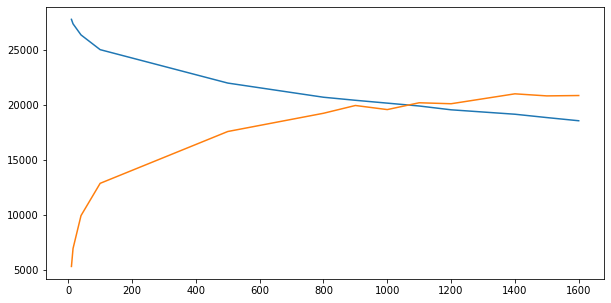

In [81]:
plt.figure(figsize = (10,5))
plt.plot(folds_iter, rmse_at_fold)
plt.plot(folds_iter, std_at_fold)
plt.show()

In [82]:
lowest_tradeoff = abs(rmse_at_fold[0]-std_at_fold[0])
best_fold = folds_iter[0]
best_rmse = rmse_at_fold[0]
best_std = std_at_fold[0]

for rmse, std, folds in zip(rmse_at_fold, std_at_fold, folds_iter):
    tradeoff = abs(rmse- std)
    if tradeoff < lowest_tradeoff:
        lowest_tradeoff = tradeoff
        best_fold = folds
        best_rmse = rmse
        best_std = std
    
print("RMSE and standard deviation intersect at ",round(best_fold,2),"folds where RMSE is", round(best_rmse,2), "standard deviation is", round(best_std,2))

RMSE and standard deviation intersect at  1100 folds where RMSE is 19878.45 standard deviation is 20171.86
